# LSI Word Embedding using K-means, Gaussian Mixture and Cosine Similarity as Clustering

In [925]:
import os.path

from gensim import corpora
from gensim.models import LsiModel
from gensim.models.coherencemodel import CoherenceModel

import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
import re

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import Normalizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.metrics.cluster import adjusted_rand_score

from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.kmedians import kmedians
from pyclustering.utils.metric import distance_metric
from pyclustering.utils.metric import type_metric
from scipy.spatial import distance

from tqdm.notebook import tqdm, tnrange
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import math
import functools
from scipy import stats

In [3]:
# Download if not downloaded
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('punkt')

In [4]:
pd.set_option('display.max_rows', 200)
plt.rcParams['figure.figsize'] = [17, 6]
plt.rcParams.update({'font.size': 12})

In [5]:
%%html
<style>
table {float:center}
</style>

# Read and Merge Data

##### Ticker to GICS (version 1)

- data from prof (bloomberg)

In [6]:
# ticker_to_gics_df = pd.read_csv('data_out/ticker_to_gics_bloomberg.csv')
# ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
# ticker_to_gics_df

##### Ticker to GICS (version 2 - better)

- data from previous code (not sure where origin)
- more data

In [428]:
ticker_to_gics_df = pd.read_csv('data_in/ticker_to_gics.csv', names=['Ticker', 'GICS'])
ticker_to_gics_df.Ticker = ticker_to_gics_df.Ticker.str.replace('/','-')
ticker_to_gics_df.GICS = ticker_to_gics_df.GICS.apply(lambda x: int(str(x)[:6]))

##### Map GICS code to name

In [429]:
gics_code_to_industry_df = pd.read_csv('data_out/gics_code_to_industry.csv')
ticker_to_gics_df = pd.merge(ticker_to_gics_df, gics_code_to_industry_df, on='GICS')[['Ticker', 'GICS Industry']]
ticker_to_gics_df.rename({'GICS Industry':'GICS'}, axis=1, inplace=True)
ticker_to_gics_df

,Ticker,GICS
0,A,Life Sciences Tools & Services
1,ADPT,Life Sciences Tools & Services
2,AVTR,Life Sciences Tools & Services
3,BIO,Life Sciences Tools & Services
4,BRKR,Life Sciences Tools & Services
...,...,...
2959,PYX,Tobacco
2960,TPB,Tobacco
2961,UVV,Tobacco
2962,VGR,Tobacco


### Helper functions

In [8]:
# For testing purposes
def longest_and_shortest_description(df):
    desc_len = df.Description.map(lambda s: len(s))
    max_i, max_n = desc_len.idxmax(), desc_len.max()
    min_i, min_n = desc_len.idxmin(), desc_len.min()
    print("LONGEST DESCRIPTION:")
    print(df.iloc[max_i].Description)
    print("SHORTEST DESCRIPTION:")
    print(df.iloc[min_i].Description)
    
def description_length_stats(df):
    desc_len = df.Description.map(lambda s: len(s))
    print('MEAN: %d'%desc_len.mean())
    print('MEDIAN: %d'%desc_len.median())
    print('MIN: %d'%desc_len.min())
    print('MAX: %d'%desc_len.max())
    

### Background info of Data

- SnP 500
    - market-capitalization-weighted index of the 500 largest U.S. publicly traded companies
- Russell 3000
    - market-capitalization-weighted equity index that provides exposure to entire U.S. stock market
    - more than 98% of total stock market capitalization
- Both considered large-cap stock indices, with stocks of companies valued at more than USD 10 billion
- Russell 3000 includes the S&P 500

### SnP Data

##### SnP Descriptions (from 10K)

- not used, as we will be filtering from the russell_desc_10K_df, which contains the tickers for snp
    - actually the russell_desc_10K_df is not russell ticker but all the tickers we have GICS clssification for

In [32]:
snp_desc_10K_df = pd.read_pickle('data_out/snp_desc_10K.pkl')

In [33]:
snp_desc_10K_df = pd.merge(snp_desc_10K_df, ticker_to_gics_df, on='Ticker')
snp_desc_10K_df = snp_desc_10K_df[['Ticker', 'Description', 'GICS']]

In [34]:
snp_desc_10K_df.head()

,Ticker,Description,GICS
0,AAL,PART I ITEM 1. BUSINESS Overview American ...,203020
1,AAPL,PART I Item 1.Business Company Background T...,452020
2,AAP,PART I Item 1. Business. Unless the context ...,255040
3,ABBV,PART I ITEM 1. BUSINESS Overview AbbVie(1) ...,352010
4,ABC,PART I ITEM 1. BUSINESS As used herein the ...,351020


In [35]:
snp_desc_10K_df.shape

(411, 3)

In [36]:
print(len(set(snp_desc_10K_df.GICS)))

60


In [37]:
description_length_stats(snp_desc_10K_df)

MEAN: 46021
MEDIAN: 38593
MIN: 5278
MAX: 169539


##### SnP Descriptions (from yahoo)

In [38]:
snp_desc_yahoo_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_yahoo.csv').dropna().reset_index(drop=True)
snp_desc_yahoo_df = pd.merge(snp_desc_yahoo_df, ticker_to_gics_df, on='Ticker')
snp_desc_yahoo_df.Industry = pd.Categorical(snp_desc_yahoo_df.Industry)
snp_desc_yahoo_df.Sector = pd.Categorical(snp_desc_yahoo_df.Sector)

In [39]:
snp_desc_yahoo_df.head()

,Ticker,Description,Sector,Industry,GICS
0,ABT,"Abbott Laboratories discovers, develops, manuf...",Healthcare,Medical Devices,351010
1,ABBV,"AbbVie Inc. discovers, develops, manufactures,...",Healthcare,Drug Manufacturers—General,352010
2,ADBE,Adobe Inc. operates as a diversified software ...,Technology,Software—Infrastructure,451030
3,MMM,"3M Company develops, manufactures, and markets...",Industrials,Specialty Industrial Machinery,201050
4,AMD,"Advanced Micro Devices, Inc. operates as a sem...",Technology,Semiconductors,453010


In [40]:
snp_desc_yahoo_df.shape

(499, 5)

In [41]:
print(len(set(snp_desc_yahoo_df.GICS)))
print(len(set(snp_desc_yahoo_df.Sector)))
print(len(set(snp_desc_yahoo_df.Industry)))

63
11
113


In [42]:
description_length_stats(snp_desc_yahoo_df)
# longest_and_shortest_description(snp_desc_yahoo_df)

MEAN: 1459
MEDIAN: 1584
MIN: 209
MAX: 2386


In [43]:
len([t for t in snp_desc_yahoo_df.Ticker if t not in list(snp_desc_10K_df.Ticker)])

129

- There seems to be alot of non-overlapping tickers in both snp data, so later we use the russell tickers for the 10K data and filter out the common ones

##### SnP Descriptions (from Wiki)

In [44]:
snp_desc_wiki_df = pd.read_csv('data_out/snp_desc_wiki_df.csv')

In [45]:
snp_desc_wiki_df = pd.merge(snp_desc_wiki_df, ticker_to_gics_df, on='Ticker')
snp_desc_wiki_df = snp_desc_wiki_df[['Ticker', 'Description', 'GICS']]

In [46]:
snp_desc_wiki_df.head()

,Ticker,Description,GICS
0,MMM,The 3M Company is an American multinational co...,201050
1,ABT,Abbott Laboratories is an American multination...,351010
2,ABBV,AbbVie is an American publicly traded biopharm...,352010
3,ABMD,Abiomed is a publicly-traded medical devices c...,351010
4,ACN,Accenture plc is a multinational professional ...,451020


In [47]:
snp_desc_wiki_df.shape

(500, 3)

In [48]:
print(len(set(snp_desc_wiki_df.GICS)))

63


In [49]:
description_length_stats(snp_desc_wiki_df)
# longest_and_shortest_description(snp_desc_wiki_df)

MEAN: 858
MEDIAN: 707
MIN: 69
MAX: 4427


In [50]:
# Should be empty
snp_desc_yahoo_df[~snp_desc_yahoo_df.Ticker.isin(snp_desc_wiki_df.Ticker)]

,Ticker,Description,Sector,Industry,GICS


##### SnP Descriptions (from business insider)

In [51]:
snp_desc_bi_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_business_insider.csv').dropna().reset_index(drop=True)
snp_desc_bi_df = pd.merge(snp_desc_bi_df, ticker_to_gics_df, on='Ticker')

In [52]:
snp_desc_bi_df.head()

,Ticker,Description,GICS
0,MMM,"3M Co. is a technology company, which manufact...",201050
1,AFL,"Aflac, Inc. is a holding company, which engage...",403010
2,AMD,"Advanced Micro Devices, Inc. engages in the pr...",453010
3,ABT,"Abbott Laboratories engages in the discovery, ...",351010
4,AAP,"Advance Auto Parts, Inc. engages in the supply...",255040


In [53]:
snp_desc_bi_df.shape

(498, 3)

In [54]:
print(len(set(snp_desc_bi_df.GICS)))

63


In [55]:
description_length_stats(snp_desc_bi_df)
# longest_and_shortest_description(snp_desc_bi_df)

MEAN: 747
MEDIAN: 724
MIN: 146
MAX: 2677


##### SnP Descriptions (from morning star)

In [56]:
snp_desc_ms_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_morning_star.csv').dropna().reset_index(drop=True)
snp_desc_ms_df = pd.merge(snp_desc_ms_df, ticker_to_gics_df, on='Ticker')

In [57]:
snp_desc_ms_df.head()

,Ticker,Description,GICS
0,ABMD,Abiomed Inc provides temporary mechanical circ...,351010
1,ATVI,Activision Blizzard was formed in 2008 by the ...,502020
2,AKAM,"Akamai operates a content delivery network, or...",451020
3,ACN,Accenture is a leading global IT services firm...,451020
4,ABT,Abbott manufactures and markets medical device...,351010


In [58]:
snp_desc_ms_df.shape

(497, 3)

In [59]:
print(len(set(snp_desc_ms_df.GICS)))

62


In [60]:
description_length_stats(snp_desc_ms_df)
longest_and_shortest_description(snp_desc_ms_df)

MEAN: 526
MEDIAN: 519
MIN: 145
MAX: 800
LONGEST DESCRIPTION:
Cisco Systems, Inc. is the world's largest hardware and software supplier within the networking solutions sector. The infrastructure platforms group includes hardware and software products for switching, routing, data center, and wireless applications. Its applications portfolio contains collaboration, analytics, and Internet of Things products. The security segment contains Cisco's firewall and software-defined security products. Services are Cisco's technical support and advanced services offerings. The company’s wide array of hardware is complemented with solutions for software-defined networking, analytics, and intent-based networking. In collaboration with Cisco's initiative on growing software and services, its revenue model is focused on increasing subscriptions and recurring sales.
SHORTEST DESCRIPTION:
Capital One is a diversified financial-services holding company, primarily involved in credit card lending, auto len

##### SnP Descriptions (from reuters)

In [61]:
snp_desc_reuters_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_reuters.csv').dropna().reset_index(drop=True)
snp_desc_reuters_df = pd.merge(snp_desc_reuters_df, ticker_to_gics_df, on='Ticker')

In [62]:
snp_desc_reuters_df.head()

,Ticker,Description,GICS
0,ABT,Abbott Laboratories is engaged in the discover...,351010
1,MMM,3M Co is a technology company. The Company ope...,201050
2,ACN,Accenture plc is a professional services compa...,451020
3,AAP,"Advance Auto Parts, Inc. provides automotive a...",255040
4,AES,The AES Corporation is a holding company. The ...,551050


In [63]:
snp_desc_reuters_df.shape

(496, 3)

In [64]:
print(len(set(snp_desc_reuters_df.GICS)))

62


In [65]:
description_length_stats(snp_desc_reuters_df)
longest_and_shortest_description(snp_desc_reuters_df)

MEAN: 939
MEDIAN: 971
MIN: 384
MAX: 1000
LONGEST DESCRIPTION:
AvalonBay Communities, Inc. is a real estate investment trust (REIT). The Company is focused on the development, redevelopment, acquisition, ownership and operation of multifamily communities primarily in New England, the New York/New Jersey metro area, the Mid-Atlantic, the Pacific Northwest, and Northern and Southern California. Its segments include Established Communities, Other Stabilized Communities and Development/Redevelopment Communities. As of June 30, 2017, the Company owned or held a direct or indirect ownership interest in 287 apartment communities containing 83,123 apartment homes in 10 states and the District of Columbia, of which 23 communities were under development and nine communities were under redevelopment. It operates its apartment communities under three core brands: Avalon, AVA and Eaves by Avalon. Its real estate investments consist of operating apartment communities, communities in various stages of

##### SnP Descriptions (from reuters india)

In [66]:
snp_desc_ri_df = pd.read_csv('scrapy_spiders/data_out/snp_desc_reuters_india.csv').dropna().reset_index(drop=True)
snp_desc_ri_df = pd.merge(snp_desc_ri_df, ticker_to_gics_df, on='Ticker')

In [67]:
snp_desc_ri_df.head()

,Ticker,Description,GICS
0,MMM,"3M Co, incorporated on June 25, 1929, is a tec...",201050
1,ABT,"Abbott Laboratories, incorporated on March 6, ...",351010
2,AAP,"Advance Auto Parts, Inc., incorporated on Augu...",255040
3,ACN,"Accenture plc, incorporated on June 10, 2009, ...",451020
4,AES,"The AES Corporation, incorporated on January 2...",551050


In [68]:
snp_desc_ri_df.shape

(486, 3)

In [69]:
print(len(set(snp_desc_ri_df.GICS)))

62


In [70]:
description_length_stats(snp_desc_ri_df)
# longest_and_shortest_description(snp_desc_ri_df)

MEAN: 4932
MEDIAN: 4196
MIN: 393
MAX: 15920


###### SnP Descriptions (from Bloomberg)

- we use russell data, but we will filter this to snp tickers in the next step

In [71]:
snp_desc_bloomberg_df = pd.read_csv('data_in/russell_desc_bloomberg.csv', names=['Ticker', 'Company', 'Description'])
snp_desc_bloomberg_df = snp_desc_bloomberg_df[['Ticker', 'Description']]
snp_desc_bloomberg_df = pd.merge(snp_desc_bloomberg_df, ticker_to_gics_df, on='Ticker')

In [72]:
snp_desc_bloomberg_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. provides core bio-a...",352030
1,AA,Alcoa Corporation manufactures metal products....,151040
2,AAL,American Airlines Group Inc. operates an airli...,203020
3,AAN,"Aaron's, Inc. rents and sells office and resid...",255040
4,AAOI,"Applied Optoelectronics, Inc. manufactures and...",452010


In [73]:
snp_desc_bloomberg_df.shape

(2757, 3)

In [74]:
print(len(set(snp_desc_bloomberg_df.GICS)))

69


In [75]:
description_length_stats(snp_desc_bloomberg_df)
longest_and_shortest_description(snp_desc_bloomberg_df)

MEAN: 280
MEDIAN: 281
MIN: 41
MAX: 395
LONGEST DESCRIPTION:
Cornerstone OnDemand, Inc. develops and markets on demand employee development computer software. The Company offers software includes learning development, enterprise social networking, performance management, and succession planning. Cornerstone markets to multi-national corporations, large domestic enterprises, midmarket companies, state and local public sector organizations, and colleges.
SHORTEST DESCRIPTION:
Cimpress PLC serves customers in Ireland.


### Russell Data

##### Russell Descriptions (from 10K)

In [76]:
russell_desc_10K_df = pd.read_pickle('data_out/russell_desc_10K.pkl')

In [77]:
russell_desc_10K_df = pd.merge(russell_desc_10K_df, ticker_to_gics_df, on='Ticker')
russell_desc_10K_df = russell_desc_10K_df[['Ticker', 'Description', 'GICS']]

In [188]:
russell_desc_10K_df.head()

,Ticker,Description,GICS
0,A,PART I Item 1. Business Overview Agilent T...,352030
1,AA,PART I Item 1. Business. (dollars in milli...,151040
2,AAL,PART I ITEM 1. BUSINESS Overview American ...,203020
3,AAN,PART I ITEM 1. BUSINESS Unless otherwise ind...,255040
4,AAOI,PART I Item 1. Business BUSINESS Overv...,452010


In [186]:
russell_desc_10K_df.shape

(2807, 3)

In [79]:
print(len(set(russell_desc_10K_df.GICS)))

69


##### Russell Descriptions (from yahoo)

In [227]:
russell_desc_yahoo_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_yahoo.csv').dropna().reset_index(drop=True)
russell_desc_yahoo_df = pd.merge(russell_desc_yahoo_df, ticker_to_gics_df, on='Ticker')

russell_desc_yahoo_df.Industry = pd.Categorical(russell_desc_yahoo_df.Industry)
russell_desc_yahoo_df.Sector = pd.Categorical(russell_desc_yahoo_df.Sector)

In [228]:
russell_desc_yahoo_df.head()

,Ticker,Description,Sector,Industry,GICS
0,AAOI,"Applied Optoelectronics, Inc. designs, manufac...",Technology,Semiconductors,452010
1,A,"Agilent Technologies, Inc. provides applicatio...",Healthcare,Diagnostics & Research,352030
2,AAL,"American Airlines Group Inc., through its subs...",Industrials,Airlines,203020
3,AAON,"AAON, Inc., together with its subsidiaries, en...",Industrials,Building Products & Equipment,201020
4,AA,"Alcoa Corporation, together with its subsidiar...",Basic Materials,Aluminum,151040


In [229]:
russell_desc_yahoo_df.shape

(2357, 5)

In [230]:
print(len(set(russell_desc_yahoo_df.GICS)))
print(len(set(russell_desc_yahoo_df.Sector)))
print(len(set(russell_desc_yahoo_df.Industry)))

69
11
142


##### Russell Descriptions (from Wiki)

In [181]:
russell_desc_wiki_df = pd.read_csv('data_out/russell_desc_wiki_df.csv').dropna().reset_index(drop=True)

In [182]:
russell_desc_wiki_df = pd.merge(russell_desc_wiki_df, ticker_to_gics_df, on='Ticker')
russell_desc_wiki_df = russell_desc_wiki_df[['Ticker', 'Description', 'GICS']]

In [183]:
russell_desc_wiki_df

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. is a global analyti...",352030
1,AA,Alcoa Corporation (a portmanteau of Aluminum C...,151040
2,AAL,American Airlines Group Inc. is an American pu...,203020
3,AAN,"Aaron's, Inc. is a lease-to-own retailer. The ...",255040
4,AAON,"AAON Inc. (NASDAQ: AAON) designs, manufactures...",201020
...,...,...,...
1951,ZIOP,"Randal J. Kirk (born March 1, 1954) is an Amer...",352010
1952,ZIXI,Zix Corporation (ZixCorp) (NASDAQ: ZIXI) is a ...,451030
1953,ZNGA,Zynga Inc. is an American social game develop...,502020
1954,ZTS,Zoetis Inc. (/zō-EH-tis/) is the world's large...,352020


In [184]:
print(len(set(russell_desc_wiki_df.GICS)))

69


In [185]:
russell_desc_wiki_df.Description.iloc[100]

'PNC Financial Services Group, Inc. (stylized as PNC) is an American bank holding company and financial services corporation based in Pittsburgh, Pennsylvania. Its banking subsidiary, PNC Bank, operates in 21 states and the District of Columbia with 2,459 branches and 9,051 ATMs. The company also provides financial services such as asset management, wealth management, estate planning, loan servicing, and information processing.PNC is ranked 7th on the list of largest banks in the United States by assets. It is the 5th largest bank by number of branches, 6th largest by deposits, and 4th largest in number of ATMs.The name "PNC" is derived from the initials of both of the bank\'s two predecessor companies: Pittsburgh National Corporation and Provident National Corporation, which merged in 1983.\n\n'

##### Russell Descriptions (from business insider)

In [195]:
russell_desc_bi_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_business_insider.csv').dropna().reset_index(drop=True)
russell_desc_bi_df = pd.merge(russell_desc_bi_df, ticker_to_gics_df, on='Ticker')

In [196]:
russell_desc_bi_df.head()

,Ticker,Description,GICS
0,AAP,"Advance Auto Parts, Inc. engages in the supply...",255040
1,AAOI,"Applied Optoelectronics, Inc. engages in the d...",452010
2,AAWW,"Atlas Air Worldwide Holdings, Inc. engages in ...",203010
3,AAT,"American Assets Trust, Inc. is a real estate i...",601010
4,AAPL,"Apple, Inc. engages in the design, manufacture...",452020


In [197]:
russell_desc_bi_df.shape

(2364, 3)

In [198]:
print(len(set(russell_desc_bi_df.GICS)))

69


In [199]:
description_length_stats(russell_desc_bi_df)
# longest_and_shortest_description(russell_desc_bi_df)

MEAN: 628
MEDIAN: 573
MIN: 120
MAX: 2677


##### Russell Descriptions (from morning star)

In [221]:
russell_desc_ms_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_morning_star.csv').dropna().reset_index(drop=True)
russell_desc_ms_df = pd.merge(russell_desc_ms_df, ticker_to_gics_df, on='Ticker')

In [222]:
russell_desc_ms_df.head()

,Ticker,Description,GICS
0,AAL,American Airlines is the world's largest airli...,203020
1,AAOI,Applied Optoelectronics Inc is a provider of f...,452010
2,AAON,AAON is a manufacturer of air-conditioning and...,201020
3,AAPL,Apple designs a wide variety of consumer elect...,452020
4,AAWW,"Atlas Air Worldwide Holdings Inc, together wit...",203010


In [223]:
russell_desc_ms_df.shape

(2330, 3)

In [224]:
print(len(set(russell_desc_ms_df.GICS)))

69


In [225]:
description_length_stats(russell_desc_ms_df)
longest_and_shortest_description(russell_desc_ms_df)

MEAN: 574
MEDIAN: 582
MIN: 132
MAX: 800
LONGEST DESCRIPTION:
Cisco Systems, Inc. is the world's largest hardware and software supplier within the networking solutions sector. The infrastructure platforms group includes hardware and software products for switching, routing, data center, and wireless applications. Its applications portfolio contains collaboration, analytics, and Internet of Things products. The security segment contains Cisco's firewall and software-defined security products. Services are Cisco's technical support and advanced services offerings. The company’s wide array of hardware is complemented with solutions for software-defined networking, analytics, and intent-based networking. In collaboration with Cisco's initiative on growing software and services, its revenue model is focused on increasing subscriptions and recurring sales.
SHORTEST DESCRIPTION:
Berkshire Hills Bancorp Inc is a holding company. It offers deposit, lending, investment, wealth management, and ins

##### Russell Descriptions (from reuters)

In [207]:
russell_desc_reuters_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_reuters.csv').dropna().reset_index(drop=True)
russell_desc_reuters_df = pd.merge(russell_desc_reuters_df, ticker_to_gics_df, on='Ticker')

In [208]:
russell_desc_reuters_df.head()

,Ticker,Description,GICS
0,AA,Alcoa Corporation (Alcoa) is engaged in the pr...,151040
1,AAP,"Advance Auto Parts, Inc. provides automotive a...",255040
2,A,"Agilent Technologies, Inc. provides applicatio...",352030
3,AAN,"Aaron's, Inc. (Aaron's) is an omnichannel prov...",255040
4,AAT,"American Assets Trust, Inc. is a full service,...",601010


In [958]:
russell_desc_reuters_df.shape

(2349, 3)

In [210]:
print(len(set(russell_desc_reuters_df.GICS)))

69


In [211]:
description_length_stats(russell_desc_reuters_df)
longest_and_shortest_description(russell_desc_reuters_df)

MEAN: 933
MEDIAN: 967
MIN: 321
MAX: 1000
LONGEST DESCRIPTION:
AvalonBay Communities, Inc. is a real estate investment trust (REIT). The Company is focused on the development, redevelopment, acquisition, ownership and operation of multifamily communities primarily in New England, the New York/New Jersey metro area, the Mid-Atlantic, the Pacific Northwest, and Northern and Southern California. Its segments include Established Communities, Other Stabilized Communities and Development/Redevelopment Communities. As of June 30, 2017, the Company owned or held a direct or indirect ownership interest in 287 apartment communities containing 83,123 apartment homes in 10 states and the District of Columbia, of which 23 communities were under development and nine communities were under redevelopment. It operates its apartment communities under three core brands: Avalon, AVA and Eaves by Avalon. Its real estate investments consist of operating apartment communities, communities in various stages of

##### Russell Descriptions (from reuters india)

In [212]:
russell_desc_ri_df = pd.read_csv('scrapy_spiders/data_out/russell_desc_reuters_india.csv').dropna().reset_index(drop=True)
russell_desc_ri_df = pd.merge(russell_desc_ri_df, ticker_to_gics_df, on='Ticker')

In [213]:
russell_desc_ri_df.head()

,Ticker,Description,GICS
0,AAP,"Advance Auto Parts, Inc., incorporated on Augu...",255040
1,AAN,"Aaron's, Inc. (Aaron's), incorporated on March...",255040
2,A,"Agilent Technologies, Inc., incorporated on Ma...",352030
3,AAT,"American Assets Trust, Inc., incorporated on J...",601010
4,ABC,"AmerisourceBergen Corporation, incorporated on...",351020


In [962]:
russell_desc_ri_df.drop_duplicates(inplace=True)

In [963]:
russell_desc_ri_df.shape

(2331, 3)

In [964]:
print(len(set(russell_desc_ri_df.GICS)))

69


In [965]:
description_length_stats(russell_desc_ri_df)
# longest_and_shortest_description(russell_desc_ri_df)

MEAN: 3959
MEDIAN: 3386
MIN: 323
MAX: 16352


###### Russell Descriptions (from Bloomberg)

- we use russell data, but we will filter this to snp tickers in the next step

In [71]:
snp_desc_bloomberg_df = pd.read_csv('data_in/russell_desc_bloomberg.csv', names=['Ticker', 'Company', 'Description'])
snp_desc_bloomberg_df = snp_desc_bloomberg_df[['Ticker', 'Description']]
snp_desc_bloomberg_df = pd.merge(snp_desc_bloomberg_df, ticker_to_gics_df, on='Ticker')

In [72]:
snp_desc_bloomberg_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. provides core bio-a...",352030
1,AA,Alcoa Corporation manufactures metal products....,151040
2,AAL,American Airlines Group Inc. operates an airli...,203020
3,AAN,"Aaron's, Inc. rents and sells office and resid...",255040
4,AAOI,"Applied Optoelectronics, Inc. manufactures and...",452010


In [73]:
snp_desc_bloomberg_df.shape

(2757, 3)

In [74]:
print(len(set(snp_desc_bloomberg_df.GICS)))

69


In [75]:
description_length_stats(snp_desc_bloomberg_df)
longest_and_shortest_description(snp_desc_bloomberg_df)

MEAN: 280
MEDIAN: 281
MIN: 41
MAX: 395
LONGEST DESCRIPTION:
Cornerstone OnDemand, Inc. develops and markets on demand employee development computer software. The Company offers software includes learning development, enterprise social networking, performance management, and succession planning. Cornerstone markets to multi-national corporations, large domestic enterprises, midmarket companies, state and local public sector organizations, and colleges.
SHORTEST DESCRIPTION:
Cimpress PLC serves customers in Ireland.


###### Russell Descriptions (from Bloomberg)

In [232]:
russell_desc_bloomberg_df = pd.read_csv('data_in/russell_desc_bloomberg.csv', names=['Ticker', 'Company', 'Description'])
russell_desc_bloomberg_df = russell_desc_bloomberg_df[['Ticker', 'Description']]
russell_desc_bloomberg_df = pd.merge(russell_desc_bloomberg_df, ticker_to_gics_df, on='Ticker')

In [233]:
russell_desc_bloomberg_df.head()

,Ticker,Description,GICS
0,A,"Agilent Technologies, Inc. provides core bio-a...",352030
1,AA,Alcoa Corporation manufactures metal products....,151040
2,AAL,American Airlines Group Inc. operates an airli...,203020
3,AAN,"Aaron's, Inc. rents and sells office and resid...",255040
4,AAOI,"Applied Optoelectronics, Inc. manufactures and...",452010


In [234]:
russell_desc_bloomberg_df.shape

(2757, 3)

In [235]:
print(len(set(russell_desc_bloomberg_df.GICS)))

69


In [236]:
description_length_stats(russell_desc_bloomberg_df)
longest_and_shortest_description(russell_desc_bloomberg_df)

MEAN: 280
MEDIAN: 281
MIN: 41
MAX: 395
LONGEST DESCRIPTION:
Cornerstone OnDemand, Inc. develops and markets on demand employee development computer software. The Company offers software includes learning development, enterprise social networking, performance management, and succession planning. Cornerstone markets to multi-national corporations, large domestic enterprises, midmarket companies, state and local public sector organizations, and colleges.
SHORTEST DESCRIPTION:
Cimpress PLC serves customers in Ireland.


## Filter descriptions to contain same tickers for each index from all data sources (ie 10K, yahoo, wiki etc.)

In [966]:
def filter_common_tickers(df_list):
    '''
    input: list of dfs with Ticker column
    output: list of filtered dfs (index reseted and sorted by ticker) in same order
    Note this wont change the original dfs in the df_list
    '''
    df_0 = df_list[0]
    df_filter_list = [df_0.Ticker.isin(df_1.Ticker) for df_1 in df_list[1:]]
    df_filter = functools.reduce(lambda x,y: x & y, df_filter_list)
    df_0 = df_0[df_filter].sort_values('Ticker').reset_index(drop=True)
    result_list = [df_0]
    
    for df_1 in df_list[1:]:
        df_1 = df_1[df_1.Ticker.isin(df_0.Ticker)].sort_values('Ticker').reset_index(drop=True)
        result_list.append(df_1)
    return result_list

### Russell Filtering

In [967]:
RUSSELL_DATA_SRCS = ['Yahoo', '10K', 'Wiki', 'Morning Star', 'Reuters', 'Reuters India', 'Bloomberg']
RUSSELL_DESC_DFS = [russell_desc_yahoo_df, russell_desc_10K_df, russell_desc_wiki_df, russell_desc_ms_df,
                    russell_desc_reuters_df, russell_desc_ri_df, russell_desc_bloomberg_df]
RUSSELL_DESC_DFS = filter_common_tickers(RUSSELL_DESC_DFS)

### Snp Filtering

- note that we take russell_desc_10K_df as snp_desc_10K_df  (as it is the scraped descriptions of all tickers which have GICS classification)
- filter with russell data as well

In [969]:
SNP_DATA_SRCS = ['Yahoo', '10K', 'Wiki', 'Morning Star', 'Reuters', 'Reuters India', 'Bloomberg']
SNP_DESC_DFS = [snp_desc_yahoo_df, russell_desc_10K_df, snp_desc_wiki_df, snp_desc_ms_df, snp_desc_reuters_df,
                 snp_desc_ri_df, snp_desc_bloomberg_df, RUSSELL_DESC_DFS[0]]
SNP_DESC_DFS = filter_common_tickers(SNP_DESC_DFS)[:-1]

### Russell_filter

In [970]:
RUSSELLFILTER_DATA_SRCS = ['Yahoo', '10K', 'Wiki', 'Morning Star', 'Reuters', 'Reuters India', 'Bloomberg']
RUSSELLFILTER_DESC_DFS = [df[~df.Ticker.isin(SNP_DESC_DFS[0].Ticker)].reset_index(drop=True) for df in RUSSELL_DESC_DFS]

##### Test

In [971]:
print([df.shape for df in SNP_DESC_DFS])
print([df.shape for df in RUSSELL_DESC_DFS])
print([df.shape for df in RUSSELLFILTER_DESC_DFS])

[(435, 5), (435, 3), (435, 3), (435, 3), (435, 3), (435, 3), (435, 3)]
[(1749, 5), (1749, 3), (1749, 3), (1749, 3), (1749, 3), (1749, 3), (1749, 3)]
[(1314, 5), (1314, 3), (1314, 3), (1314, 3), (1314, 3), (1314, 3), (1314, 3)]


# Data Src Analytics

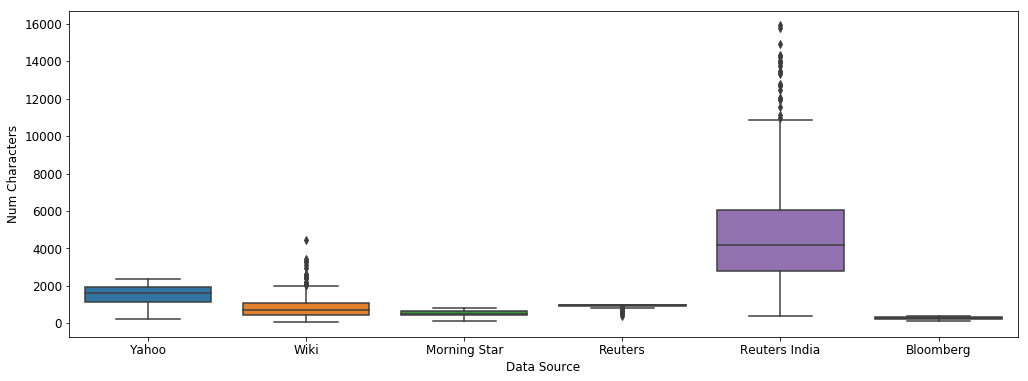

In [241]:
desc_lens = [df.Description.apply(len) for df in SNP_DESC_DFS]
len_df = pd.concat(desc_lens, axis=1)
len_df.columns = SNP_DATA_SRCS
len_df.drop('10K', axis=1, inplace=True)
ax = sns.boxplot(data=len_df)
ax.set(ylabel="Num Characters", xlabel='Data Source')

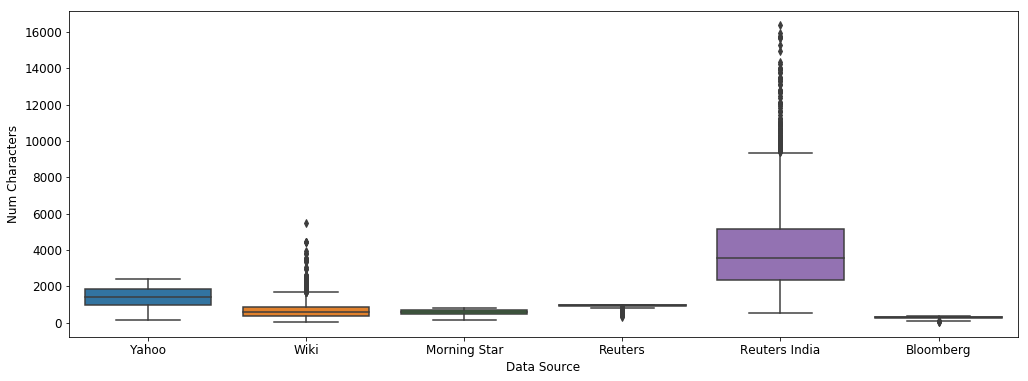

In [240]:
desc_lens = [df.Description.apply(len) for df in RUSSELL_DESC_DFS]
len_df = pd.concat(desc_lens, axis=1)
len_df.columns = RUSSELL_DATA_SRCS
len_df.drop('10K', axis=1, inplace=True)
ax = sns.boxplot(data=len_df)
ax.set(ylabel="Num Characters", xlabel='Data Source')

# Global Vars: Tickers, Description, Classifier to be used

- put yahoo as 1st data_src as it also has sector and sub-industry classification (cos the STANDARD CLASSIFIER  will be used from the first element of DESC_DFS)
- if you just change the STANDARD_CLASSIFIER variable you can go jump to the 'Run all Clustering algos' header to continue running

In [996]:
# To Set
INDEX = 'russell'
DATA_SRCS = RUSSELL_DATA_SRCS
DESC_DFS = RUSSELL_DESC_DFS
STANDARD_CLASSIFIER = 'GICS' #GICS, Sector, Industry

desc_lists = [desc_df['Description'] for desc_df in DESC_DFS]
NUM_INDUSTRIES =  len(set(DESC_DFS[0][STANDARD_CLASSIFIER])) #69 for GICS

print(NUM_INDUSTRIES)

69


##### Pre Processing

- Used Snowball stemmer as it is a slightly improved version of Porter stemmer
- lemmatization takes longer, and increases feature size

In [997]:
STOP_FILES = ['StopWords_GenericLong.txt', 'StopWords_DatesandNumbers.txt', 'StopWords_Geographic.txt', 
              'StopWords_Currencies.txt', 'StopWords_Names.txt']
STOP_WORDS = []

for file in STOP_FILES:
    df = pd.read_csv('data_in/Stop Words/%s'%file, sep='|',header=None,encoding='latin1')
    file_stop_words = list(df[0].str.lower().str.strip())
    STOP_WORDS.extend(file_stop_words)

STOP_WORDS.extend(stopwords.words('english'))
STOP_WORDS = set(STOP_WORDS)
len(STOP_WORDS)

12766

- Note for finance jargon we dont have much apostrophes (we can use the TweetTokeniser for that)

In [998]:
def get_wordnet_pos(nltk_pos):
    """Map POS tag to so lemmatize() accepts input"""
    tag = nltk_pos[0]
    NLTK_TO_WORDNET_POS = {"J": wordnet.ADJ,
                            "N": wordnet.NOUN,
                            "V": wordnet.VERB,
                            "R": wordnet.ADV}
    return NLTK_TO_WORDNET_POS.get(tag, wordnet.NOUN)

def preprocess_data(doc_list):
    """
    Input  : docuemnt list
    Purpose: preprocess text (tokenize, removing stopwords, and stemming)
    Output : preprocessed text
    """
    tokenizer = RegexpTokenizer(r'\w+')
    p_stemmer = PorterStemmer()
    s_stemmer = SnowballStemmer(language='english')
    lemmatizer = WordNetLemmatizer()
    processed_doc_list = []

    for doc in tqdm(doc_list):
        lower_doc = doc.lower()
        clean_doc = lower_doc.replace("_", "").replace('\n', ' ').replace(',', ' ')
        rem_num_doc = re.sub('[0-9]+', '', clean_doc)
        
        token_list = tokenizer.tokenize(rem_num_doc) # tokeniser removes special characters (except _)
        token_list = [i for i in token_list if len(i)>=3]
        stopped_token_list = [i for i in token_list if not i in STOP_WORDS]
#         word_reduced_token_list = [p_stemmer.stem(i) for i in stopped_token_list]
#         word_reduced_token_list = [s_stemmer.stem(i) for i in stopped_token_list]
        word_reduced_token_list = [lemmatizer.lemmatize(w, get_wordnet_pos(pos)) 
                                     for w, pos in nltk.pos_tag(stopped_token_list)]
        processed_doc = ' '.join(word_reduced_token_list) # Untokenize
        processed_doc_list.append(processed_doc)
    
    return processed_doc_list

In [999]:
preped_desc_lists = [preprocess_data(desc_list) for desc_list in desc_lists]

In [1000]:
#Test
print(len(preped_desc_lists[0]))
preped_desc_lists[2][0]

1749


'agilent technology global analytical instrumentation manufacture company headquarters agilent establish spin result ipo agilent large history silicon time company analytical instrument software service consumables entire laboratory workflow agilent focus product service market food environmental forensics pharmaceutical diagnostics chemical energy research company produce test measurement equipment electronics division spin form keysight'

##### Tdidf vectorization

- using max_df and min_df significantly reduced feature size
- using lemmatization increased feature size

<font size="5">
$$
idf(t,D) = log(\frac{|D|}{1 + \mid d \in D: t \in d \mid})
$$
</font>

In [1001]:
vectorizer = TfidfVectorizer(stop_words='english', max_features= None, max_df = 0.5, min_df=2, smooth_idf=True,
                             ngram_range=(1,1))
# Note attributes of vectorizer will be from the last prepped_desc_only
# dtm - Document Matrix (sparse matrix)
dtms = [vectorizer.fit_transform(preped_desc_list) for preped_desc_list in preped_desc_lists]

In [1002]:
shapes = [dtm.shape for dtm in dtms]
pd.DataFrame(shapes, index=DATA_SRCS, columns=['num_row', 'num_col (vector length)'])

,num_row,num_col (vector length)
Yahoo,1749,6305
10K,1749,27533
Wiki,1749,4407
Morning Star,1749,3367
Reuters,1749,4407
Reuters India,1749,12079
Bloomberg,1749,2112


| Descriptions | Unique Words (features)
| :- | -: | 
| SnP (10K) | 25834 |
| SnP (yahoo) | 7263 |
| Russell (10K) | 78546 |
| Russell (yahoo) | 16855 |
| Russell (10K, from previous project) | 20025 |


- df = (0.5.2)
    - p_stem = 10870
    - s_stem = 10877
    - lemma = 14315

###### Check if words used in tdidf model are meaningful by looking at most infrequent and frequent words

In [150]:
features = vectorizer.get_feature_names()
features_df = pd.DataFrame(vectorizer.idf_, columns=['IDF'], index=features)
features_df.sort_values('IDF', inplace=True)
display(features_df.head(100))
display(features_df.tail(100))
display(features_df)

,IDF
service,1.740400
product,1.832030
offer,2.143564
operate,2.245100
worldwide,2.324507
customer,2.341174
market,2.375365
manufacture,2.438166
state,2.456858
corporation,2.466337


,IDF
nutritional,6.021685
nutrition,6.021685
nurse,6.021685
nuclear,6.021685
northeastern,6.021685
nitrogen,6.021685
neuroscience,6.021685
networking,6.021685
negotiate,6.021685
navigation,6.021685


,IDF
service,1.740400
product,1.832030
offer,2.143564
operate,2.245100
worldwide,2.324507
...,...
interventional,6.021685
interstate,6.021685
intermediate,6.021685
lifestyle,6.021685


# DTM Visualisation

- visualise data in 2d using PCA and LSI to see which clustering approach will work best
- look at GICS Sector classification (for easier visualisation as there are only 11 classes)

In [698]:
dtm = dtms[0].toarray()
pca = PCA(n_components=2, random_state=0)
dtm_pca = pca.fit_transform(dtm)

In [719]:
#not used
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(dtm)
X.mean(axis=0)

array([ 5.38604892e-17, -1.15362932e-16, -1.52655666e-16, ...,
        2.38612360e-16, -1.12367286e-16, -8.77907634e-17])

- You use MinMaxScaler when you do not assume that the shape of all your features follows a normal distribution

In [671]:
lsa = TruncatedSVD(2, algorithm = 'arpack', random_state=0)
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa_normalised = Normalizer(copy=True).fit_transform(dtm_lsa) # normalisae so each vector is len 1

In [701]:
pca2 = PCA(n_components=0.5, random_state=0) #Choose components to explain 50% of the variance
dtm_pca2 = pca2.fit_transform(dtm)
len(pca2.explained_variance_ratio_)

85

- 85 components required to explain 50% of variance in data

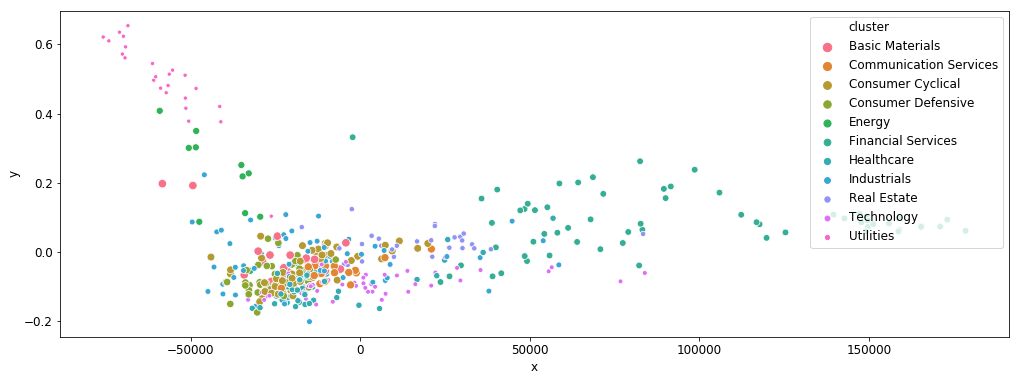

In [672]:
df = pd.DataFrame(dtm_pca, columns=['x', 'y'])
df['cluster'] = DESC_DFS[0].Sector
# plt.figure(figsize=(14,10))
sns.scatterplot(x='x', y='y', hue='cluster', size='cluster', data=df)

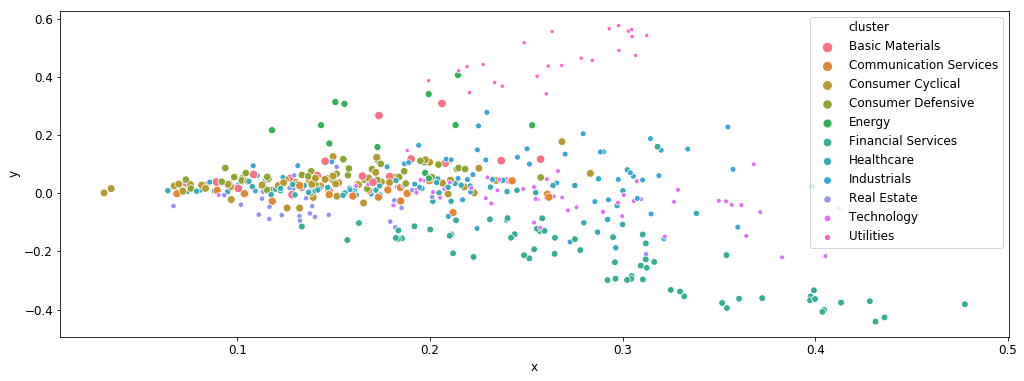

In [673]:
df = pd.DataFrame(dtm_lsa, columns=['x', 'y'])
df['cluster'] = DESC_DFS[0].Sector
# plt.figure(figsize=(14,10))
sns.scatterplot(x='x', y='y', hue='cluster', size='cluster', data=df)

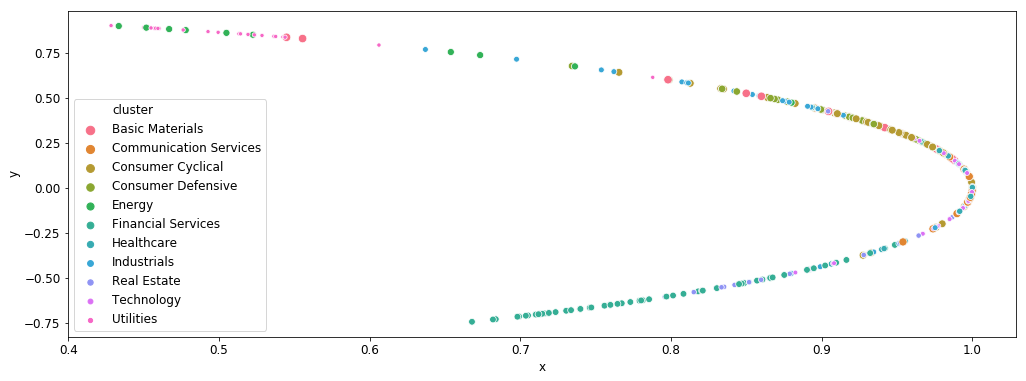

In [676]:
df = pd.DataFrame(dtm_lsa_normalised, columns=['x', 'y'])
df['cluster'] = DESC_DFS[0].Sector
# plt.figure(figsize=(14,10))
sns.scatterplot(x='x', y='y', hue='cluster', size='cluster', data=df)

- the way the clustering is occuring seems to suggest that cosine similarity is a better measure
- clearly normalising takes away some information
- and that you should not normalise after (hmm not sure, bcos this should not affect cosine similarity)

# Clustering Algos

### K-Means

- sum of squared Euclidean distances

In [167]:
def kmeans_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++', n_init=10, max_iter=300, random_state=0)
    kmeans.fit(dtm)
    return kmeans.labels_
#     pred = kmeans.predict(dtm)
#     return pred

### K-medioids

- aka partitioning around medoids (PAM)
- K-means choses point average as cluster center while k-medoids chooses data points as centers (medoids)
    - thus k-medioids works with arbitraty distances while k-means only works with euclidean dist
    - A medoid is an element in a cluster whose average dissimilarity to all objects in cluster is minimal (i.e most centrally located point in cluster)
- more robust to noise and outliers as compared to k-means because it minimizes a sum of pairwise dissimilarities instead of a sum of squared Euclidean distances

In [682]:
def get_cluster_allocation_from_clusters(clusters, return_str=False):
    num_elemts = max(functools.reduce(lambda x,y: x+y, clusters)) + 1
    idx_clusters = np.zeros(num_elemts).astype(int)
    i = 0
    for cluster in clusters:
        idx_clusters[cluster] = i
        i +=1
    if return_str:
        idx_clusters = idx_clusters.astype(str)
        idx_clusters =  list(map(lambda j: 'Cluster ' + j, idx_clusters))
        return idx_clusters
    else:
        return idx_clusters

In [688]:
def kmedioids_cluster(dtm, return_str=False):
    '''
    input: Document Matrix, return str()
    output: list indicating clusters
    '''
    cosine_distance = lambda x, y: distance.cosine(x,y)
    metric = distance_metric(type_metric.USER_DEFINED, func=cosine_distance) # type_metric.EUCLIDEAN
    initial_medoids = list(range(NUM_INDUSTRIES))
    
    kmedoids_instance = kmedoids(dtm, initial_medoids, metric=metric)
    kmedoids_instance.process()
    clusters = kmedoids_instance.get_clusters()
    cluster_allocation = get_cluster_allocation_from_clusters(clusters, return_str=return_str)
    return cluster_allocation

### K-medians

In [ ]:
def kmedians_cluster(dtm, return_str=False):
    initial_medians = dtm[:NUM_INDUSTRIES]
    kmedians_instance = kmedians(dtm, initial_medians)
    kmedians_instance.process()
    clusters = kmedians_instance.get_clusters()
    medians = kmedians_instance.get_medians()
    cluster_allocation = get_cluster_allocation_from_clusters(clusters, return_str=return_str)
    return cluster_allocation

### DBSCAN

- Usecase: Non-flat geometry, uneven cluster sizes

In [ ]:
# from sklearn.cluster import DBSCAN
# from sklearn.preprocessing import StandardScaler

# X = StandardScaler().fit_transform(dtm)

# db = DBSCAN(eps=0.3, min_samples=10).fit(X)
# core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
# core_samples_mask[db.core_sample_indices_] = True
# labels = db.labels_

### Gaussian Mixture

- kmeans is a distance based model, while gmm is a distribution based model

In [744]:
def gmm_cluster(dtm):
    '''
    input: Document Matrix
    output: list indicating clusters
    '''
    gmm = GaussianMixture(n_components=NUM_INDUSTRIES, random_state=0)
    gmm.fit(dtm)
    pred = gmm.predict(dtm)
    return pred

### Test Cluster Allocation

In [684]:
dtm = dtms[0].toarray()
cluster_allocation = kmedioids_cluster(dtm, return_str=True)

pca = PCA(n_components=2, random_state=0)
dtm_pca = pca.fit_transform(dtm)

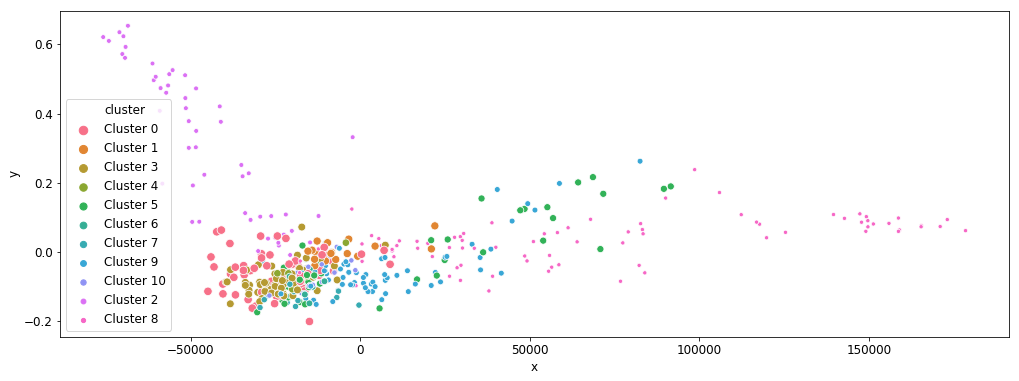

In [685]:
df = pd.DataFrame(dtm_pca, columns=['x', 'y'])
df['cluster'] = cluster_allocation
# plt.figure(figsize=(14,10))
sns.scatterplot(x='x', y='y', hue='cluster', size='cluster', data=df)

# Determine Optimal Number of Topics

##### Coherence Score

- coherence score will distinguish between good and bad topics
- Choosing a ‘k’ that marks the end of a rapid growth of topic coherence usually offers meaningful and interpretable topics

In [168]:
num_topics = 11
words = 5

In [171]:
tokenized_desc_list = [word_tokenize(doc) for doc in preped_desc_lists[0]]
dictionary = corpora.Dictionary(tokenized_desc_list)
dtm_gensim = [dictionary.doc2bow(doc) for doc in tokenized_desc_list] #this dtm has a unique structure
lsamodel = LsiModel(dtm_gensim, num_topics=num_topics, id2word = dictionary)
lsamodel.print_topics(num_topics=num_topics, num_words=words)

[(0,
  '0.494*"service" + 0.381*"product" + 0.353*"company" + 0.309*"segment" + 0.208*"offer"'),
 (1,
  '-0.608*"service" + 0.570*"product" + -0.182*"management" + 0.163*"system" + 0.131*"company"'),
 (2,
  '-0.528*"system" + 0.310*"product" + 0.294*"insurance" + -0.230*"solution" + -0.161*"equipment"'),
 (3,
  '0.404*"gas" + 0.341*"company" + 0.300*"natural" + -0.231*"product" + 0.227*"operate"'),
 (4,
  '-0.515*"segment" + -0.357*"insurance" + 0.292*"company" + 0.206*"service" + -0.204*"commercial"'),
 (5,
  '-0.334*"health" + -0.294*"care" + 0.237*"investment" + 0.220*"product" + 0.215*"banking"'),
 (6,
  '0.462*"segment" + -0.378*"insurance" + 0.192*"operate" + -0.191*"gas" + 0.161*"banking"'),
 (7,
  '0.313*"company" + -0.296*"care" + 0.292*"insurance" + 0.230*"system" + -0.222*"service"'),
 (8,
  '-0.466*"system" + 0.441*"solution" + -0.262*"care" + 0.209*"software" + -0.179*"health"'),
 (9,
  '-0.325*"solution" + 0.315*"service" + 0.252*"product" + -0.223*"health" + -0.221*"comp

In [175]:
coherence_values = []
model_list = []
NUM_TOPICS_RNG = range(2, 150, 1)
for num_topics in tqdm(NUM_TOPICS_RNG):
    model = LsiModel(dtm_gensim, num_topics=num_topics, id2word = dictionary)
    model_list.append(model)
    coherencemodel = CoherenceModel(model=model, texts=tokenized_desc_list, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

In [ ]:
model.print_topics(num_topics=num_topics, num_words=words)
# coherence_values

In [ ]:
plt.plot(NUM_TOPICS_RNG, coherence_values, label='Coherence score')
plt.xlabel("Number of Topics")
plt.ylabel("Coherence score")
plt.xticks(RNG[::5])
plt.legend()
plt.grid()
plt.show()

- 0.55 and above are good values for coherence scores
- 2,7 topics seems to be best

##### Optimal number of clusters

- Elbow method
- sihoulette value
    - measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation)
    - [-1,1]

In [ ]:
lsa_test = TruncatedSVD(n_components=200, algorithm = 'arpack')
dtm_lsa_test = lsa_test.fit_transform(dtm)
dtm_lsa_test = Normalizer(copy=False).fit_transform(dtm_lsa_test) # normalisae so each vector is len 1

##### Important words for each Topic

In [ ]:
features = vectorizer.get_feature_names()
topic_words = []
for i, comp in enumerate(lsa_test.components_):
    terms_comp = zip(features, comp)
    sorted_words = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
    sorted_words_clean = [tup[0] for tup in sorted_words]
    topic_words.append(sorted_words_clean)
topic_df = pd.DataFrame(topic_words, index=['Topic '+str(i) for i in range(lsa_test.components_.shape[0])])

In [ ]:
topic_df.head(50)

- words seem pretty sensible
- n_components is the number of topics to be extracted, so you shd use 64

# Determine Optimal Number of Clusters

- using kmeans

In [ ]:
kmeans_kwargs = {
    "init": "random",
    "n_init": 10,
    "max_iter": 300,
    "random_state": 42,
}

gics_sil_score = silhouette_score(dtm_lsa_test, desc_df.GICS)

silhouette_coefficients = []
sse = []
iters = []
a,b = 2,200
for k in tnrange(a,b):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(dtm_lsa_test)
    score = silhouette_score(dtm_lsa_test, kmeans.labels_)
    silhouette_coefficients.append(score)
    sse.append(kmeans.inertia_)
    iters.append(kmeans.n_iter_) # dosent give much information usu from [4,20]


In [ ]:
plt.plot(range(a, b), sse)
plt.xticks(range(a, b,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of Squared Errors (SSE)")
plt.grid()
plt.show()

- can see there is a slight elbow at 11

In [ ]:
plt.plot(range(a,b), silhouette_coefficients, label='k-means')
plt.axhline(gics_sil_score, label='GICS', color='r')
plt.xticks(range(a,b,10))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.legend()
plt.grid()
plt.show()

- best score at 112, which is the number of subindustries
- k-means easily outperforms GICS for silhouette coefficient, which makes sense as k-means is clustering wrt to the given vectors so it should in a sense optimise the silhouette coefficient

# Run all Clustering algos

##### Abit about LSI

- leveraging the idea that meaning can be extracted from context (ie words from the same document should have some similarity)

- Why not PCA
    - both use SVD and leverage the idea that meaning can be extracted from context
    - but PCA does SVD on the covariance matrix
    - PCA is more general and can be used on high dimentional datasets  while LSI is more specific to text corpora

In [1003]:
#Test
dtms[0].shape

(1749, 6305)

In [1004]:
std_class_df = pd.DataFrame(DESC_DFS[0][STANDARD_CLASSIFIER].cat.codes, columns=[STANDARD_CLASSIFIER])
cluster_dfs_list = [DESC_DFS[0][['Ticker']], std_class_df]
for i in tnrange(len(DATA_SRCS)):
    data_src = DATA_SRCS[i]
    for k in tnrange(50, 401, 50):
        # LSI Embedding
        lsa_k = TruncatedSVD(k, algorithm = 'arpack', random_state=0)
        dtm_lsa_k = lsa_k.fit_transform(dtms[i])
        dtm_lsa_k = Normalizer(copy=False).fit_transform(dtm_lsa_k)
        # K-Means
        clusters_k = kmeans_cluster(dtm_lsa_k)
        cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['{}_lsi_{}_kmeans'.format(data_src, str(k))]))
        # K-Medioids
        clusters_k = kmedioids_cluster(dtm_lsa_k)
        cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['{}_lsi_{}_kmediods'.format(data_src, str(k))]))
        # K-Medians
        pass
        # GMM
        clusters_k = gmm_cluster(dtm_lsa_k)
        cluster_dfs_list.append(pd.DataFrame(clusters_k, columns=['{}_lsi_{}_gmm'.format(data_src, str(k))]))
        # Cosine_similarity
        pass
    
all_cluster = pd.concat(cluster_dfs_list, axis=1)

In [1005]:
all_cluster.head()

,Ticker,GICS,Yahoo_lsi_50_kmeans,Yahoo_lsi_50_kmediods,Yahoo_lsi_50_gmm,Yahoo_lsi_100_kmeans,Yahoo_lsi_100_kmediods,Yahoo_lsi_100_gmm,Yahoo_lsi_150_kmeans,Yahoo_lsi_150_kmediods,...,Bloomberg_lsi_250_gmm,Bloomberg_lsi_300_kmeans,Bloomberg_lsi_300_kmediods,Bloomberg_lsi_300_gmm,Bloomberg_lsi_350_kmeans,Bloomberg_lsi_350_kmediods,Bloomberg_lsi_350_gmm,Bloomberg_lsi_400_kmeans,Bloomberg_lsi_400_kmediods,Bloomberg_lsi_400_gmm
0,A,43,18,0,19,24,0,66,14,0,...,50,14,0,53,61,0,62,45,0,40
1,AAL,17,25,5,49,27,5,56,0,1,...,49,43,1,21,33,1,27,23,1,22
2,AAON,8,29,2,45,65,2,14,49,2,...,25,1,2,52,33,2,64,29,2,60
3,AAP,31,36,3,64,48,3,15,2,3,...,28,5,3,59,13,3,55,32,29,48
4,AAPL,54,37,40,33,40,4,8,34,4,...,10,31,4,64,20,4,55,32,4,20


###### Save clustering to the next available file by index

In [1006]:
file_list = os.listdir('data_out/all_clusters/')
max_idx = -1
for file in file_list:
    split_list = file.split('_')
    if split_list[0] == INDEX:
        idx = int(split_list[-1][:-4])
        max_idx = max(max_idx, idx)
        
savepath = 'data_out/all_clusters/%s_clusters_%d.csv'%(INDEX, max_idx + 1)
all_cluster.to_csv(savepath, index=False)
print('Saved to: %s'%savepath)

Saved to: data_out/all_clusters/russell_clusters_0.csv


# Evaluation

In [855]:
# all_cluster = pd.read_csv('data_out/all_clusters/snp_clusters_2.csv')
# all_cluster.head()

### Method 1 - Ticker returns correlations

- regression of the daily return series of each stock with the return of the industry that the stock belongs to
- criterion is the the average of all R2s from the universe
- 5 years of daily returns used (same as previous project)

In [1007]:
ticker_price_df = pd.read_csv('data_in/russell_price.csv', index_col=0) 
# Can use this path for SnP: 'data_out/ticker_price_df.csv'

In [1008]:
ticker_price_df.columns = ticker_price_df.columns.str.replace('/', '-')
ticker_return_df = ticker_price_df.pct_change()
ticker_return_df

,A,AA,AAL,AAN,AAOI,AAON,AAP,AAPL,AAT,AAWW,...,ZION,ZIOP,ZIXI,ZNGA,ZS,ZTS,ZUMZ,ZUO,ZYNE,ZYXI
20150102,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20150105,-0.018737,-0.057933,-0.000650,-0.003919,-0.012975,-0.033973,-0.013177,-0.028175,0.011396,-0.036555,...,-0.037468,-0.011696,-0.019718,-0.007326,1.062500,-0.006004,0.019105,0.428571,0.160714,-0.111803
20150106,-0.015577,0.007351,-0.015498,-0.037378,-0.037559,-0.015815,-0.000704,0.000093,0.007836,-0.021222,...,-0.038192,-0.021696,-0.025862,-0.003690,-0.154545,-0.009754,-0.012327,0.030000,0.188923,-0.062550
20150107,0.013273,0.025880,-0.000565,0.030317,-0.039024,0.009115,0.021485,0.014021,0.018955,0.017959,...,0.009356,0.012097,-0.002950,-0.007407,0.088889,0.020642,0.047322,0.000000,0.270186,-0.020018
20150108,0.029974,0.028461,0.012260,0.016196,0.011168,0.024715,0.008769,0.038426,0.005963,0.037220,...,0.014184,-0.005976,0.076923,-0.037313,0.023041,0.015398,0.027805,-0.050971,0.431948,-0.013616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20200518,0.025371,0.171171,0.091814,0.066134,0.024540,0.069529,0.040060,0.023561,0.066448,0.084015,...,0.119171,0.102041,0.032833,-0.009950,0.000000,0.030826,0.087572,0.000000,0.000000,0.000000
20200519,-0.020201,-0.007692,-0.023303,-0.032964,0.010778,-0.022518,0.035924,-0.005779,-0.034615,0.007802,...,-0.033730,-0.074074,0.019074,0.010050,0.000000,0.022219,-0.034716,0.000000,0.000000,0.000000
20200520,-0.003172,0.078811,0.023859,0.046173,0.020142,0.008213,-0.000736,0.019448,0.028287,0.028645,...,0.065024,0.080000,0.074866,0.012438,0.000000,-0.007444,-0.000999,0.000000,0.000000,0.000000
20200521,-0.011749,-0.008383,0.002026,-0.001777,0.005807,0.029009,-0.006852,-0.007455,0.004649,-0.006774,...,-0.012532,0.047138,0.023217,-0.000614,0.000000,-0.022574,0.092000,0.000000,0.000000,0.000000


In [1009]:
# Tickers to remove if no ticker data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in ticker_return_df.columns]
print(tickers_with_no_data)

[]


In [1010]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

,Ticker,GICS,Yahoo_lsi_50_kmeans,Yahoo_lsi_50_kmediods,Yahoo_lsi_50_gmm,Yahoo_lsi_100_kmeans,Yahoo_lsi_100_kmediods,Yahoo_lsi_100_gmm,Yahoo_lsi_150_kmeans,Yahoo_lsi_150_kmediods,...,Bloomberg_lsi_250_gmm,Bloomberg_lsi_300_kmeans,Bloomberg_lsi_300_kmediods,Bloomberg_lsi_300_gmm,Bloomberg_lsi_350_kmeans,Bloomberg_lsi_350_kmediods,Bloomberg_lsi_350_gmm,Bloomberg_lsi_400_kmeans,Bloomberg_lsi_400_kmediods,Bloomberg_lsi_400_gmm
0,A,43,18,0,19,24,0,66,14,0,...,50,14,0,53,61,0,62,45,0,40
1,AAL,17,25,5,49,27,5,56,0,1,...,49,43,1,21,33,1,27,23,1,22
2,AAON,8,29,2,45,65,2,14,49,2,...,25,1,2,52,33,2,64,29,2,60
3,AAP,31,36,3,64,48,3,15,2,3,...,28,5,3,59,13,3,55,32,29,48
4,AAPL,54,37,40,33,40,4,8,34,4,...,10,31,4,64,20,4,55,32,4,20


In [1011]:
all_cluster_filtered.shape

(1749, 170)

In [1012]:
mtds_R2_list = []

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    R2_list = []
    for i in range(NUM_INDUSTRIES):
        cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
        cluster_ticker_returns = ticker_return_df[cluster_tickers]
        mean_return = cluster_ticker_returns.mean(axis=1)
        cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_ticker_returns.iteritems()]
        R2_list.extend(cluster_R2)
    avg_R2 = sum(R2_list)/len(R2_list)
    if cluster_mtd == STANDARD_CLASSIFIER:
        STANDARD_CLASSIFIER_R2 = avg_R2
    else:
        data_src, _, k, clustering_mtd = cluster_mtd.split('_')
        mtds_R2_list.append([data_src, int(k), clustering_mtd, avg_R2])

avg_R2_df = pd.DataFrame(mtds_R2_list, columns=['Data_src', 'k', 'Clustering mtd', 'Average R2'])

In [1013]:
avg_R2_df.head()

,Data_src,k,Clustering mtd,Average R2
0,Yahoo,50,kmeans,0.594897
1,Yahoo,50,kmediods,0.587388
2,Yahoo,50,gmm,0.587599
3,Yahoo,100,kmeans,0.586169
4,Yahoo,100,kmediods,0.586446


In [990]:
grp_df = avg_R2_df.groupby('Data_src')
best_R2_df = grp_df.apply(lambda df: df[df['Average R2'] == df['Average R2'].max()])
best_R2_df = best_R2_df.droplevel(level=1).drop('Data_src', axis=1)
best_R2_df['pct_cng'] = (best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2)/STANDARD_CLASSIFIER_R2 * 100
best_R2_df.sort_values('pct_cng', inplace=True, ascending=False)
best_R2_df

,k,Clustering mtd,Average R2,pct_cng
Data_src,,,,
Reuters India,50,gmm,0.763084,0.783569
10K,100,kmeans,0.761451,0.567916
Yahoo,100,gmm,0.758574,0.187920
Reuters,50,gmm,0.755057,-0.276674
Morning Star,50,kmeans,0.753360,-0.500706
Bloomberg,100,gmm,0.745645,-1.519741
Wiki,50,gmm,0.740530,-2.195275


- best values occur at low k values, and usually k means

GICS R2: 0.757


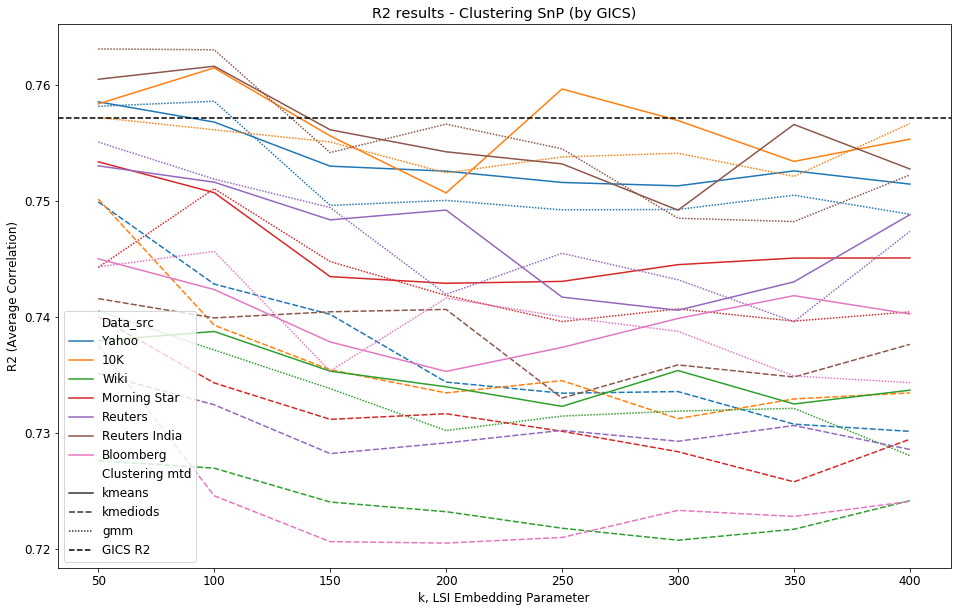

In [991]:
TITLE = 'R2 results - Clustering SnP (by GICS)'
print('GICS R2: %.3f'%STANDARD_CLASSIFIER_R2)
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_R2, color="black", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [1014]:
grp_df = avg_R2_df.groupby('Data_src')
best_R2_df = grp_df.apply(lambda df: df[df['Average R2'] == df['Average R2'].max()])
best_R2_df = best_R2_df.droplevel(level=1).drop('Data_src', axis=1)
best_R2_df['pct_cng'] = (best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2)/STANDARD_CLASSIFIER_R2 * 100
best_R2_df.sort_values('pct_cng', inplace=True, ascending=False)
best_R2_df

,k,Clustering mtd,Average R2,pct_cng
Data_src,,,,
10K,50,kmeans,0.597714,0.712337
Yahoo,50,kmeans,0.594897,0.237623
Reuters India,200,kmeans,0.594324,0.141170
Reuters,50,gmm,0.592554,-0.157093
Morning Star,300,gmm,0.589628,-0.650054
Bloomberg,50,gmm,0.584937,-1.440569
Wiki,150,kmeans,0.576191,-2.914206


GICS R2: 0.593


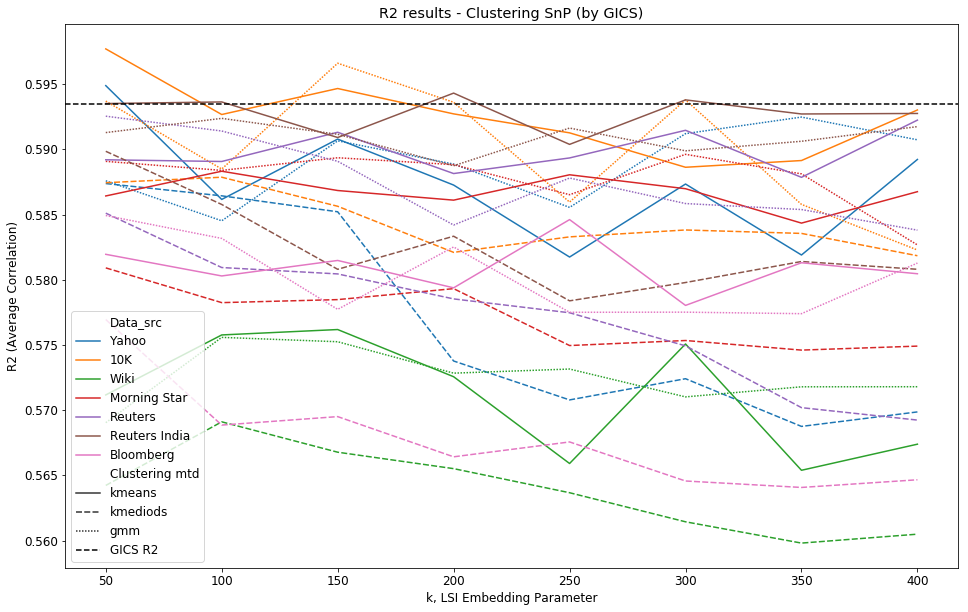

In [1015]:
TITLE = 'R2 results - Clustering SnP (by GICS)'
print('GICS R2: %.3f'%STANDARD_CLASSIFIER_R2)
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_R2, color="black", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
grp_df = avg_R2_df.groupby('Data_src')
best_R2_df = grp_df.apply(lambda df: df[df['Average R2'] == df['Average R2'].max()])
best_R2_df = best_R2_df.droplevel(level=1).drop('Data_src', axis=1)
best_R2_df['pct_cng'] = (best_R2_df['Average R2'] - STANDARD_CLASSIFIER_R2)/STANDARD_CLASSIFIER_R2 * 100
best_R2_df.sort_values('pct_cng', inplace=True, ascending=False)
best_R2_df

In [ ]:
TITLE = 'R2 results - Clustering SnP (by GICS)'
print('GICS R2: %.3f'%STANDARD_CLASSIFIER_R2)
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_R2, color="black", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

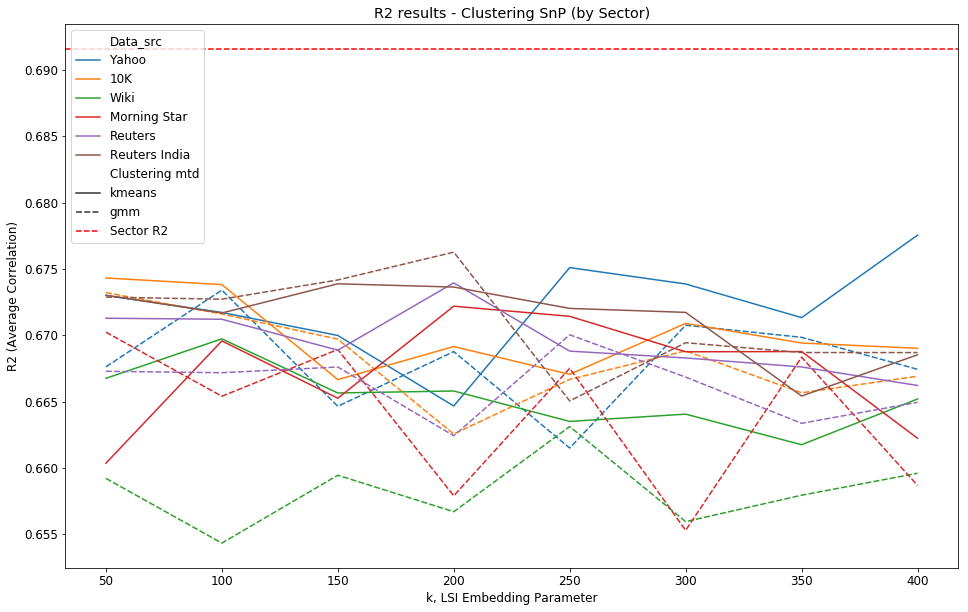

In [261]:
TITLE = 'R2 results - Clustering SnP (by Sector)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_R2, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

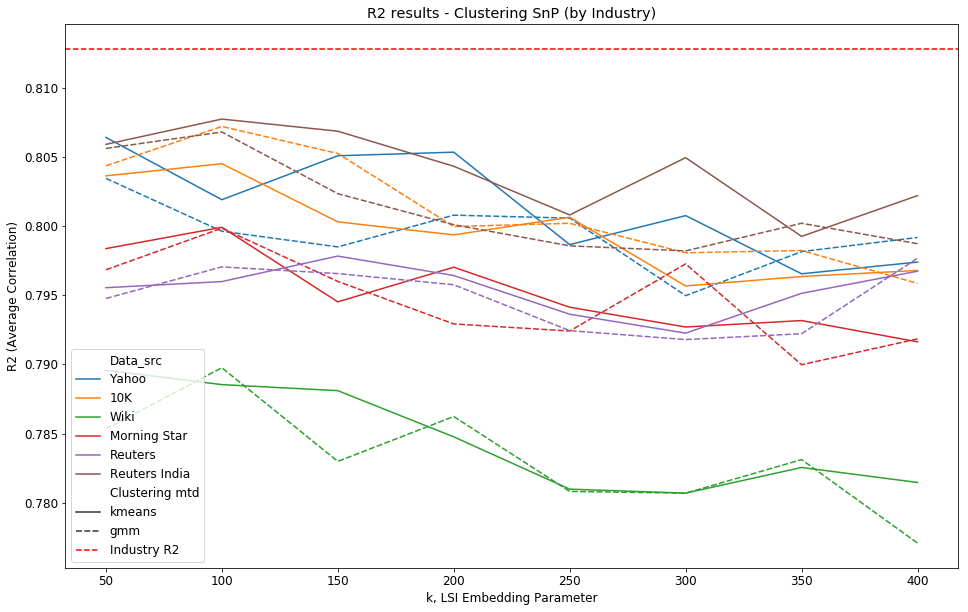

In [273]:
TITLE = 'R2 results - Clustering SnP (by Industry)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_R2, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
ax = sns.lineplot(data=avg_R2_df, x='k', y='Average R2', hue='Clustering mtd', style='Data_src', sort=False)
ax.axhline(STANDARD_CLASSIFIER_R2, color="red", linestyle="--", label='GICS R2')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='R2 (Average Correlation)', title='R2 results - Clustering Russell')

### Method 2a - Inter Industry Variation of firm ratios

- The second criterion used is the across-industry variation (Hoberg and Phillips)
- Need to handle missing values of ratios
- in previous paper they removed outlier so higher score
- The higher the score the better

In [1064]:
ticker_ratios_df = pd.read_csv('data_out/russell_ratios_clean.csv') #'data_out/snp_ratios_df.csv'
ticker_ratios_df.head()

,Ticker,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE
0,MMM,78520.0,7.80,1.00,0.1537,0.1040,0.4992
1,ABT,139580.0,4.49,0.97,0.1115,0.0459,0.1156
2,ABBV,112510.0,NaN,0.78,0.2477,0.1180,NaN
3,ABMD,6530.0,6.24,0.86,0.2414,0.1372,0.2028
4,ACN,114850.0,7.59,1.03,0.1113,0.1344,0.3401


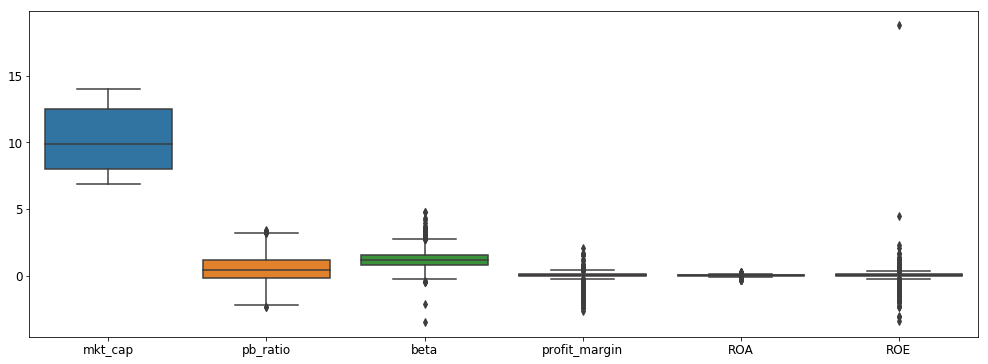

In [1063]:
sns.boxplot(data=df)

(2409, 6)


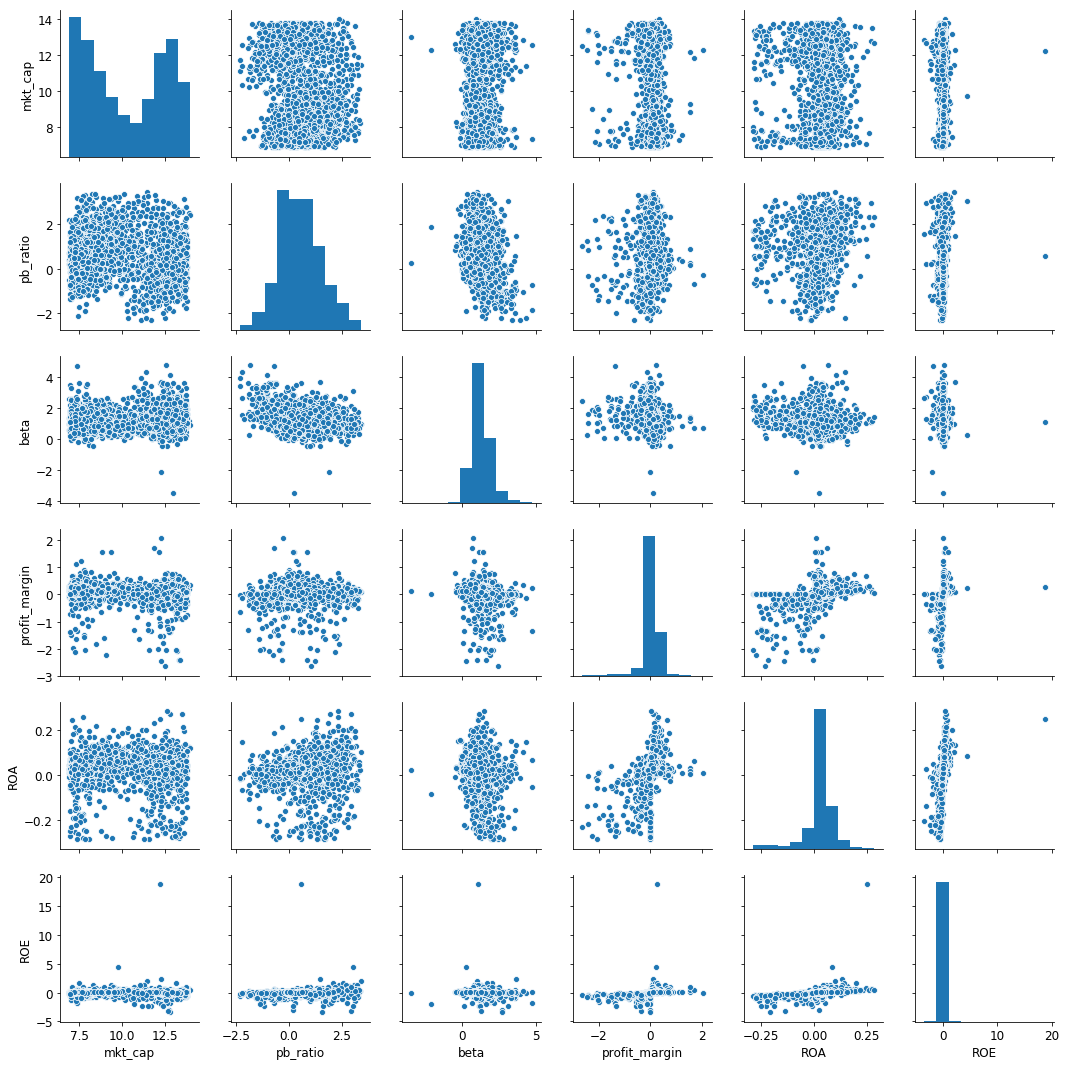

In [1068]:
df = ticker_ratios_df.iloc[:,1:]
df.pb_ratio = np.log(df.pb_ratio)
df.mkt_cap = np.log(df.mkt_cap)
df.dropna(inplace=True)

df = df[(np.abs(stats.zscore(df)) < 2.5).all(axis=1)]
print(df.shape)
sns.pairplot(df)

# ticker_ratios_df = df

In [887]:
# Normalise values
ticker_ratios_normalised_df = ticker_ratios_df.copy()
# for header in ticker_ratios_df.columns[1:]:
#     col = ticker_ratios_df[header]
#     ticker_ratios_normalised_df[header] = (col - col.mean())/col.std()
ticker_ratios_normalised_df

,Ticker,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE
0,MMM,78520.0,7.80,1.00,0.1537,0.1040,0.4992
1,ABT,139580.0,4.49,0.97,0.1115,0.0459,0.1156
2,ABBV,112510.0,NaN,0.78,0.2477,0.1180,NaN
3,ABMD,6530.0,6.24,0.86,0.2414,0.1372,0.2028
4,ACN,114850.0,7.59,1.03,0.1113,0.1344,0.3401
...,...,...,...,...,...,...,...
2886,PMT,1060.0,0.49,1.09,0.0000,-0.0433,-0.2376
2887,COLL,560220.0,6.41,1.07,-0.0421,-0.0117,-0.1106
2888,FLIC,412810.0,1.06,0.52,0.3688,0.0096,0.1045
2889,GWR,6300.0,1.81,1.31,0.0928,0.0308,0.0580


In [888]:
# Tickers to remove if no ratio data
tickers_with_no_data = [ticker for ticker in all_cluster.Ticker if ticker not in list(ticker_ratios_df.Ticker)]
print(tickers_with_no_data)
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)

['CE', 'LB']


In [889]:
all_cluster_filtered = all_cluster[~all_cluster.Ticker.isin(tickers_with_no_data)].reset_index(drop=True)
all_cluster_filtered.head()

,Ticker,GICS,Yahoo_lsi_50_kmeans,Yahoo_lsi_50_kmediods,Yahoo_lsi_50_gmm,Yahoo_lsi_100_kmeans,Yahoo_lsi_100_kmediods,Yahoo_lsi_100_gmm,Yahoo_lsi_150_kmeans,Yahoo_lsi_150_kmediods,...,Bloomberg_lsi_250_gmm,Bloomberg_lsi_300_kmeans,Bloomberg_lsi_300_kmediods,Bloomberg_lsi_300_gmm,Bloomberg_lsi_350_kmeans,Bloomberg_lsi_350_kmediods,Bloomberg_lsi_350_gmm,Bloomberg_lsi_400_kmeans,Bloomberg_lsi_400_kmediods,Bloomberg_lsi_400_gmm
0,A,43,25,0,37,44,0,27,0,0,...,2,12,0,2,60,0,2,48,0,37
1,AAL,17,24,1,31,38,1,24,44,1,...,27,25,1,60,10,1,49,11,1,18
2,AAP,31,22,2,41,52,52,57,20,2,...,23,60,2,31,30,2,60,28,2,40
3,AAPL,54,27,3,1,3,3,1,3,35,...,16,26,3,16,4,3,44,15,3,14
4,ABBV,41,17,59,6,42,4,59,31,4,...,36,32,4,42,15,4,27,26,4,44


<font size="5">
$$
\sigma_v = \frac
                {\sqrt{\sum_{i=0}^{K} n_i \frac{(v_m - v_i)^2}{N}}}
                {\sqrt{\sum_{j=0}^{N} \frac{(v_m - f_j)^2}{N}}            }
$$
</font>

- $K$ - num industries
- $N$ - num firms
- $n_i$ - num firms in industry i
- $v_m$ - overall mean value of characteristic
- $v_i$ - mean value of characteristic in industry i
- $f_j$ - value of characteristic for firm j


- numerator is weighted average, while denomenator is simple average
- N will cancel out eventually
- the larger this number the more will spread out the avg industry ratios are from the mean ratio
- larger the better
- should be lesser than 1 (as avg industry ratio shd vary less)


- recheck method for Na values

In [890]:
def cluster_variation(s):
    '''
    input: series of values from a cluster
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() # ignores NaN values
    n  = s.count() # count non-NaN values
    variation = n * (v_m[s.name] - mean)**2
    return variation

In [892]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_variation_list = []

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
        
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    v_m = all_cluster_with_ratio[RATIO_NAMES_LIST].mean()
    variation_df = filter_df.groupby(cluster_mtd).aggregate(cluster_variation)
    variation_series = variation_df.sum()
    N_ratios = ticker_ratios_normalised_df[RATIO_NAMES_LIST].count() # count non-NaN values
    weighted_deviation_series = np.sqrt(variation_series/N_ratios)

    normaliser_series = ticker_ratios_normalised_df[RATIO_NAMES_LIST].std()

    sigma_v = list(weighted_deviation_series/normaliser_series)
    avg_sigma_v = sum(sigma_v)/len(sigma_v) # mean
    if cluster_mtd == STANDARD_CLASSIFIER:
        STANDARD_CLASSIFIER_RV = sigma_v
        STANDARD_CLASSIFIER_AVG_RV = avg_sigma_v
    else:
        data_src, _, k, clustering_mtd = cluster_mtd.split('_')
        row = [data_src, int(k), clustering_mtd] + sigma_v + [avg_sigma_v]
        ratio_variation_list.append(row)

cols = ['Data_src', 'k', 'Clustering mtd'] + RATIO_NAMES_LIST + ['Average Ratio Variation']
ratio_variation_df = pd.DataFrame(ratio_variation_list, columns= cols)

In [894]:
STANDARD_CLASSIFIER_RV

[0.09467783678036024,
 0.29791897188589245,
 0.0046842704392023185,
 0.04195889748661371,
 0.07263272659414403,
 0.266937423279495]

In [1020]:
ratio_variation_df

,Data_src,k,Clustering mtd,mkt_cap,pb_ratio,beta,profit_margin,ROA,ROE,Average Ratio Variation
0,Yahoo,50,kmeans,0.110270,0.228663,0.004456,0.039543,0.072825,0.228728,0.114081
1,Yahoo,50,kmediods,0.081718,0.210235,0.004449,0.035798,0.069457,0.378719,0.130063
2,Yahoo,50,gmm,0.107681,0.221520,0.004511,0.041055,0.073880,0.307846,0.126082
3,Yahoo,100,kmeans,0.098481,0.233054,0.004628,0.041594,0.070784,0.193679,0.107037
4,Yahoo,100,kmediods,0.073762,0.175082,0.003756,0.030839,0.068946,0.415079,0.127911
5,Yahoo,100,gmm,0.092864,0.223298,0.004398,0.041085,0.071876,0.198394,0.105319
6,Yahoo,150,kmeans,0.124307,0.189503,0.004446,0.040652,0.070888,0.291355,0.120192
7,Yahoo,150,kmediods,0.106288,0.171109,0.003870,0.033853,0.067878,0.464700,0.141283
8,Yahoo,150,gmm,0.105731,0.202468,0.004215,0.039991,0.069994,0.254481,0.112813
9,Yahoo,200,kmeans,0.103122,0.193480,0.004388,0.042845,0.068971,0.208607,0.103569


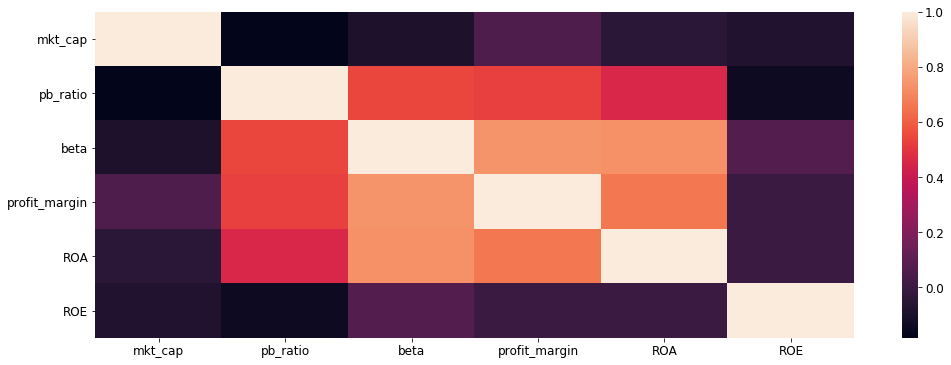

In [1027]:
corr = ratio_variation_df.iloc[:,3:-1].corr()
sns.heatmap(corr)

GICS Ratio Variation (mktcap): 0.30


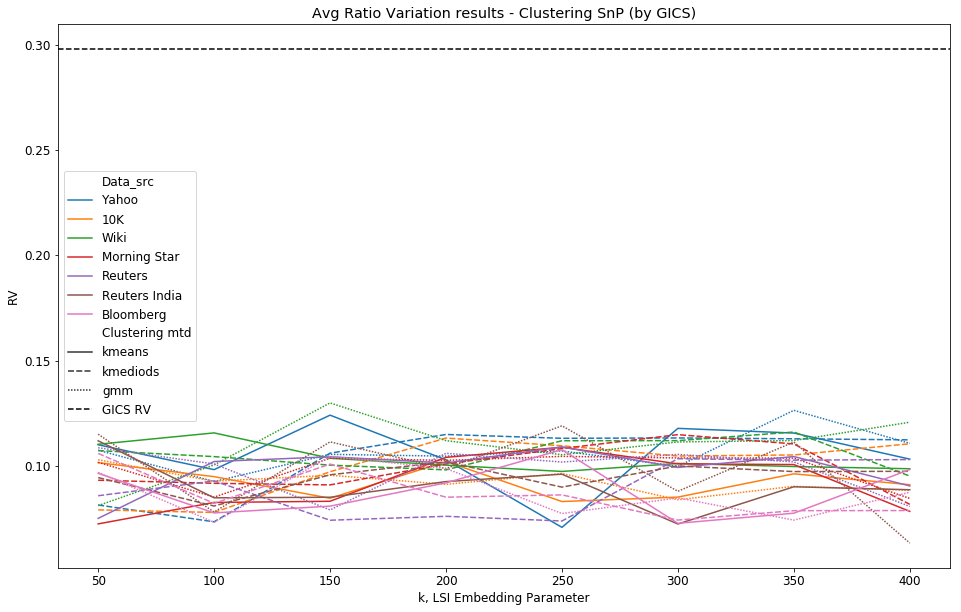

In [896]:
TITLE = 'Avg Ratio Variation results - Clustering SnP (by GICS)'
print('GICS Ratio Variation (mktcap): %.2f'%STANDARD_CLASSIFIER_RV[1])
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=ratio_variation_df, x='k', y='mkt_cap', hue='Data_src', style='Clustering mtd')
ax.axhline(STANDARD_CLASSIFIER_RV[1], color="black", linestyle="--", label=STANDARD_CLASSIFIER+' RV')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='RV', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

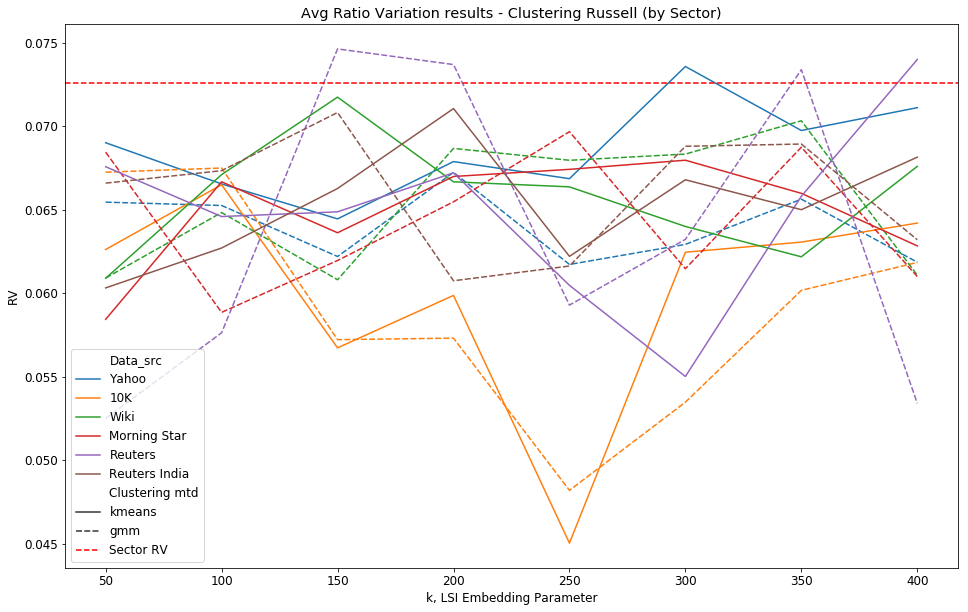

In [310]:
TITLE = 'Avg Ratio Variation results - Clustering Russell (by Sector)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=ratio_variation_df, x='k', y='Average Ratio Variation', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_AVG_RV, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' RV')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='RV', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

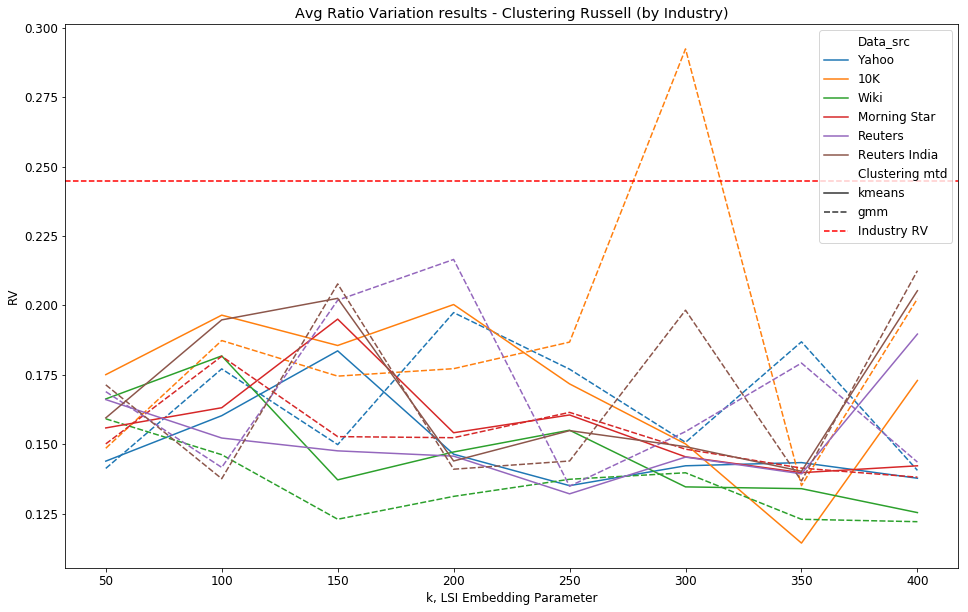

In [288]:
TITLE = 'Avg Ratio Variation results - Clustering Russell (by Industry)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=ratio_variation_df, x='k', y='Average Ratio Variation', hue='Data_src', style='Clustering mtd', sort=False)
ax.axhline(STANDARD_CLASSIFIER_AVG_RV, color="red", linestyle="--", label=STANDARD_CLASSIFIER+' RV')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='RV', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio', title='Variation results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/2_4.png')

### Method 2b - Absolute distances to cluster center (my method)

- not a good guage i think

In [ ]:
def cluster_distance(s):
    '''
    input: series
    output: sum(x - x_bar), sum of absolute distances to cluster center
    '''
    mean = s.mean() #ignores NaN values
    abs_dist = abs(s-mean).sum()
    return abs_dist

In [ ]:
RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
ratio_distances_dict = {}

for cluster_mtd in tqdm(all_cluster_filtered.columns):
    if cluster_mtd == 'Ticker':
        continue
    
    filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
    ratio_distance_sum = filter_df.groupby(cluster_mtd).aggregate(cluster_distance).sum()
    non_na_count_series = filter_df.count()[1:]
    ratio_distance_avg_list = list(ratio_distance_sum/non_na_count_series)
    ratio_distances_dict[cluster_mtd] = ratio_distance_avg_list
    
ratio_distances_df = pd.DataFrame.from_dict(ratio_distances_dict, orient='index', columns=RATIO_NAMES_LIST)

In [ ]:
ratio_distances_df['Average Ratio Cluster Spread'] = ratio_distances_df.mean(axis=1)
ratio_distances_df

In [ ]:
avg_ratio_df = ratio_distances_df[['Average Ratio Cluster Spread']]
GICS_RATIO = ratio_distances_df.loc['GICS', 'Average Ratio Cluster Spread']
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = avg_ratio_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
    list_of_dfs.append(mtd_df)

avg_ratio_pivot_df = pd.concat(list_of_dfs, axis=1)
print(GICS_RATIO)
avg_ratio_pivot_df

In [ ]:
ax = sns.lineplot(data=avg_ratio_pivot_df, sort=False)
ax.axhline(GICS_RATIO, color="red", linestyle="--")
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Average Ratio')

### Method 2b - Financial Ratio average cluster distance (averaged by mkt cap)

### Method 3a - Similarity to GICS by probability (among ticker with same GICS classification)

- probability that if GICS classifies 2 elements in the same industry, they are in the same categorisation in the clustering method
- if you include same or different industry similarity, the similarity scores will be very high because most of the time the classifications will be different
- in this case you can do the first method because the number of classes is fixed, so you cant put all as the same class

In [897]:
all_cluster.head()

,Ticker,GICS,Yahoo_lsi_50_kmeans,Yahoo_lsi_50_kmediods,Yahoo_lsi_50_gmm,Yahoo_lsi_100_kmeans,Yahoo_lsi_100_kmediods,Yahoo_lsi_100_gmm,Yahoo_lsi_150_kmeans,Yahoo_lsi_150_kmediods,...,Bloomberg_lsi_250_gmm,Bloomberg_lsi_300_kmeans,Bloomberg_lsi_300_kmediods,Bloomberg_lsi_300_gmm,Bloomberg_lsi_350_kmeans,Bloomberg_lsi_350_kmediods,Bloomberg_lsi_350_gmm,Bloomberg_lsi_400_kmeans,Bloomberg_lsi_400_kmediods,Bloomberg_lsi_400_gmm
0,A,43,25,0,37,44,0,27,0,0,...,2,12,0,2,60,0,2,48,0,37
1,AAL,17,24,1,31,38,1,24,44,1,...,27,25,1,60,10,1,49,11,1,18
2,AAP,31,22,2,41,52,52,57,20,2,...,23,60,2,31,30,2,60,28,2,40
3,AAPL,54,27,3,1,3,3,1,3,35,...,16,26,3,16,4,3,44,15,3,14
4,ABBV,41,17,59,6,42,4,59,31,4,...,36,32,4,42,15,4,27,26,4,44


In [898]:
temp_df = pd.merge(all_cluster, all_cluster, on=STANDARD_CLASSIFIER)
cross_df = temp_df[temp_df.Ticker_x != temp_df.Ticker_y]
similarity_dict = {}

for mtd in all_cluster.columns:
    if mtd not in ['Ticker', 'GICS']:
        mtd_x = mtd + '_x'
        mtd_y = mtd + '_y'
        similarity_dict[mtd] = sum(cross_df[mtd_x] == cross_df[mtd_y])/len(cross_df)

similarity_df = pd.DataFrame.from_dict(similarity_dict, orient='index', columns=['Similarity Probability'])

In [899]:
similarity_df

,Similarity Probability
Yahoo_lsi_50_kmeans,0.300077
Yahoo_lsi_50_kmediods,0.308552
Yahoo_lsi_50_gmm,0.296610
Yahoo_lsi_100_kmeans,0.323190
Yahoo_lsi_100_kmediods,0.297381
Yahoo_lsi_100_gmm,0.309707
Yahoo_lsi_150_kmeans,0.310478
Yahoo_lsi_150_kmediods,0.301233
Yahoo_lsi_150_gmm,0.309322
Yahoo_lsi_200_kmeans,0.302773


In [900]:
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = similarity_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd] 
    list_of_dfs.append(mtd_df)

similarity_pivot_df = pd.concat(list_of_dfs, axis=1)
similarity_pivot_df

,kmeans,gmm
lsi,0.300077,0.296610
lsi,0.323190,0.309707
lsi,0.310478,0.309322
lsi,0.302773,0.283513
lsi,0.300077,0.319723
lsi,0.342835,0.289291
lsi,0.283128,0.256163
lsi,0.300847,0.265023
lsi,0.390216,0.376733
lsi,0.404083,0.350539


c:\users\sival\appdata\local\programs\python\python36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



ValueError: could not convert string to float: 'lsi'

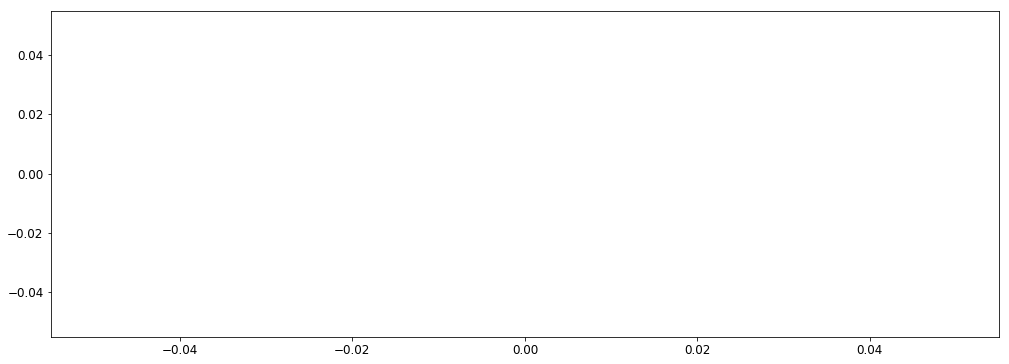

In [901]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering SnP using 10K reports')
plt.savefig('data_out/images/3_1.png')

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering SnP using yahoo desc')
plt.savefig('data_out/images/3_2.png')

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering Russell using 10K reports')
plt.savefig('data_out/images/3_3.png')

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS'
       , title='Similarity Probability results - Clustering Russell using yahoo desc')
plt.savefig('data_out/images/3_4.png')

### Method 3b - Adjusted random index

- comparing similarity between clusterings
- can plot heatmap

<font size="5">
$$
Rand Index, R = \frac
                {a + b}
                {n \choose 2}
$$
</font>

- $a$ - no. of pairs of elements in  same subset in both partitions
- $b$ - no. of pairs of elements in  diff subset in both partitions

In [1016]:
mtds_clustering_similarity_list = []

for cluster_mtd in tqdm(all_cluster.columns):
    if cluster_mtd in ('Ticker', STANDARD_CLASSIFIER):
        continue
    
    similarity_score = adjusted_rand_score(all_cluster[STANDARD_CLASSIFIER], all_cluster[cluster_mtd])
    data_src, _, k, clustering_mtd = cluster_mtd.split('_')
    mtds_clustering_similarity_list.append([data_src, int(k), clustering_mtd, similarity_score])

clustering_similarity_df = pd.DataFrame(mtds_clustering_similarity_list, columns=['Data_src', 'k', 'Clustering mtd', 'Clustering Similarity'])

In [1017]:
clustering_similarity_df.head()

,Data_src,k,Clustering mtd,Clustering Similarity
0,Yahoo,50,kmeans,0.335519
1,Yahoo,50,kmediods,0.392238
2,Yahoo,50,gmm,0.346613
3,Yahoo,100,kmeans,0.401690
4,Yahoo,100,kmediods,0.458003


In [994]:
grp_df = clustering_similarity_df.groupby('Data_src')
best_similarity_df = grp_df.apply(lambda df: df[df['Clustering Similarity'] == df['Clustering Similarity'].max()])
best_similarity_df = best_similarity_df.droplevel(level=1).drop('Data_src', axis=1)
best_similarity_df.sort_values('Clustering Similarity', inplace=True, ascending=False)
best_similarity_df

,k,Clustering mtd,Clustering Similarity
Data_src,,,
10K,150,gmm,0.416761
Yahoo,50,kmeans,0.394510
Reuters India,100,kmeans,0.390953
Reuters,50,gmm,0.390935
Morning Star,50,kmeans,0.386631
Bloomberg,50,kmeans,0.358889
Wiki,100,gmm,0.328417


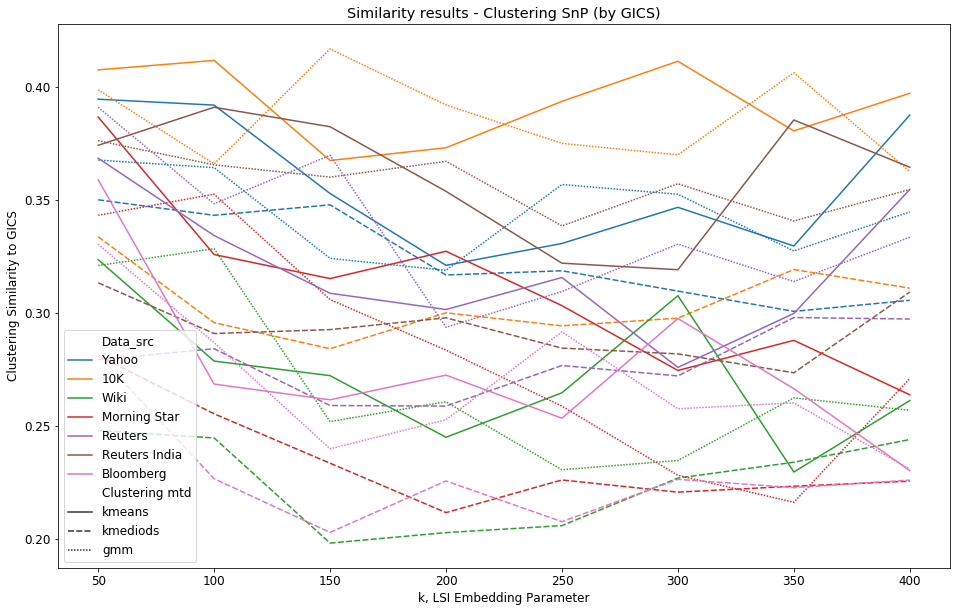

In [995]:
TITLE = 'Similarity results - Clustering SnP (by GICS)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=clustering_similarity_df, x='k', y='Clustering Similarity', hue='Data_src', style='Clustering mtd')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Clustering Similarity to GICS', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [1018]:
grp_df = clustering_similarity_df.groupby('Data_src')
best_similarity_df = grp_df.apply(lambda df: df[df['Clustering Similarity'] == df['Clustering Similarity'].max()])
best_similarity_df = best_similarity_df.droplevel(level=1).drop('Data_src', axis=1)
best_similarity_df.sort_values('Clustering Similarity', inplace=True, ascending=False)
best_similarity_df

,k,Clustering mtd,Clustering Similarity
Data_src,,,
10K,100,kmeans,0.515590
Reuters India,50,kmediods,0.465800
Yahoo,100,kmediods,0.458003
Reuters,200,kmeans,0.373960
Morning Star,350,kmediods,0.335859
Bloomberg,50,kmediods,0.333436
Wiki,50,kmediods,0.311373


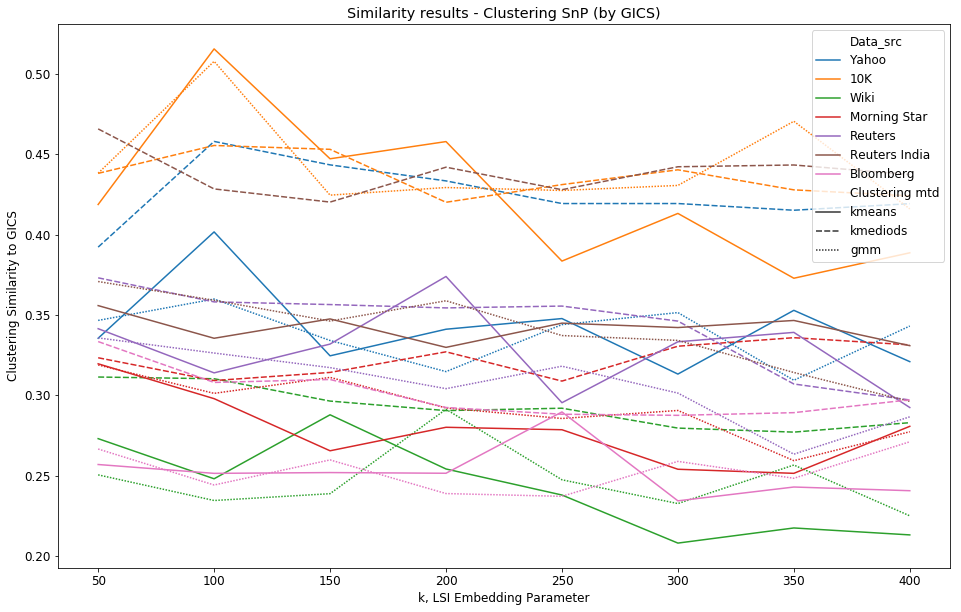

In [1019]:
TITLE = 'Similarity results - Clustering SnP (by GICS)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=clustering_similarity_df, x='k', y='Clustering Similarity', hue='Data_src', style='Clustering mtd')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Clustering Similarity to GICS', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

In [ ]:
grp_df = clustering_similarity_df.groupby('Data_src')
best_similarity_df = grp_df.apply(lambda df: df[df['Clustering Similarity'] == df['Clustering Similarity'].max()])
best_similarity_df = best_similarity_df.droplevel(level=1).drop('Data_src', axis=1)
best_similarity_df.sort_values('Clustering Similarity', inplace=True, ascending=False)
best_similarity_df

In [ ]:
TITLE = 'Similarity results - Clustering SnP (by GICS)'
plt.figure(figsize=(16,10))
ax = sns.lineplot(data=clustering_similarity_df, x='k', y='Clustering Similarity', hue='Data_src', style='Clustering mtd')
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Clustering Similarity to GICS', title=TITLE)
plt.legend()
# plt.savefig(TITLE)

### Method 3c - Similarity to GICS by probability of similar classification type among ANY 2 tickers

- might be better than Adjusted random index as the number of clusters is fixed so we are not facing cases where we have a clustering assigning all to one cluster
- takes much longer

<font size="5">
$$
Similarity Probablity, S = \frac
                {a}
                {n \choose 2}
$$
</font>

In [ ]:
L = len(all_cluster)
similarity_series = pd.Series(0, all_cluster.columns)

for i in tnrange(L):
    for j in range(L):
        if i != j:
            similarity = (all_cluster.iloc[i] == all_cluster.iloc[j])
            if not similarity.GICS:
                similarity = ~similarity
            similarity_series += similarity.astype(int)

In [ ]:
similarity_df = pd.DataFrame((similarity_series/similarity_series.GICS)[2:], columns=['Similarity Probability'])

In [ ]:
MTDS = ['kmeans', 'gmm']
list_of_dfs = []

for mtd in MTDS:
    mtd_df = similarity_df.filter(regex=mtd, axis=0)
    mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
    mtd_df.columns = [mtd] 
    list_of_dfs.append(mtd_df)

similarity_pivot_df = pd.concat(list_of_dfs, axis=1)
similarity_pivot_df

In [ ]:
ax = sns.lineplot(data=similarity_pivot_df, sort=False)
ax.set(xlabel='k, LSI Embedding Parameter', ylabel='Similarity probability with GICS')

### Method 4 - Majority element ratios (my method)

In [ ]:
all_cluster.head()

In [ ]:
# Test
all_cluster[all_cluster.GICS == 3]

In [ ]:
def majority_element_proportion(s):
    '''
    input: series
    output: proportion of majority element in series
    '''
    l = len(s)
    n = s.value_counts().iloc[0]
    return n/l

In [ ]:
correctness_ratios_df = all_cluster.iloc[:,1:].groupby('GICS').aggregate(majority_element_proportion)

In [ ]:
correctness_ratios_df.plot.bar()
# sns.barplot(correctness_ratios_df)

In [ ]:
sns.distplot(correctness_ratios_df.iloc[:,0], bins=15)

- Since most of the ratios seem to be above the 0.5 ratio, the clustring seems to have clustered pretty closely to GICS standard

# Extra

### Cosine Similarity

- taking too long to run

In [ ]:
x = [((1,),(2,),3), ((4,),(1458,),6)]

mcorr = ((1458,), (1830,), 1.0000000000000004)
list(filter(lambda tup: (tup[0] not in mcorr) and (tup[1] not in mcorr), x))

In [ ]:
((1,2), (4,)) in (1,)

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(np.asmatrix(dtm) * np.asmatrix(dtm).T)
    L = corr.shape[0]
    
    cluster_corrs = []
    for i in range(L):
        for j in range(i+1,L):
            corr_tuple = ((i,), (j,), corr[i][j])
            cluster_corrs.append(corr_tuple)
            
    cluster_list = [(i,) for i in range(L)]
    
    num_iter = L - NUM_INDUSTRIES
    for x in range(num_iter):
        max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
        # filters ur max_corr_tup also
        print(max_corr_tup)
        cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
        new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
        cluster_list.remove(max_corr_tup[0])
        cluster_list.remove(max_corr_tup[1])
        for cluster in cluster_list:
            # Similarity
            n = len(new_cluster) * len(cluster)
            total_similarity = 0
            for cpy_1 in new_cluster:
                for cpy_2 in cluster:
                    total_similarity += corr[cpy_1][cpy_2]
            similarity = total_similarity / n
            corr_tuple = (new_cluster, cluster, similarity)
            cluster_corrs.append(corr_tuple)
        cluster_list.append(new_cluster)
    
    if len(cluster_list) != NUM_INDUSTRIES:
        raise Exception()
        
    pred = np.full(N, -1)
    for i in range(NUM_INDUSTRIES):
        cluster = list(cluster_list[i])
        pred[cluster] = [i] * len(cluster)
    return pred

In [ ]:
cosine_similarity(dtm_lsa)

In [ ]:
dtmx = dtm_lsa
corr = np.asarray(np.asmatrix(dtmx) * np.asmatrix(dtmx).T)
L = corr.shape[0]

cluster_corrs = []
for i in range(L):
    for j in range(i+1,L):
        corr_tuple = ((i,), (j,), corr[i][j])
        cluster_corrs.append(corr_tuple)

cluster_list = [(i,) for i in range(L)]

num_iter = L - NUM_INDUSTRIES
for x in range(num_iter):
    max_corr_tup = max(cluster_corrs, key = lambda tup: tup[2])
    # filters ur max_corr_tup also
    print(max_corr_tup)
    cluster_corrs = list(filter(lambda tup: (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup),cluster_corrs))
    new_cluster = max_corr_tup[0] + max_corr_tup[1] # concatenate tups
    cluster_list.remove(max_corr_tup[0])
    cluster_list.remove(max_corr_tup[1])
    for cluster in cluster_list:
        # Similarity
        n = len(new_cluster) * len(cluster)
        total_similarity = 0
        for cpy_1 in new_cluster:
            for cpy_2 in cluster:
                total_similarity += corr[cpy_1][cpy_2]
        similarity = total_similarity / n
        corr_tuple = (new_cluster, cluster, similarity)
        cluster_corrs.append(corr_tuple)
    cluster_list.append(new_cluster)

if len(cluster_list) != NUM_INDUSTRIES:
    raise Exception()

pred = np.full(N, -1)
for i in range(NUM_INDUSTRIES):
    cluster = list(cluster_list[i])
    pred[cluster] = [i] * len(cluster)

In [ ]:
def t(tup):
    print((tup[0] not in max_corr_tup), (tup[1] not in max_corr_tup))
    return (tup[0] not in max_corr_tup) and (tup[1] not in max_corr_tup)
list(filter(t,cluster_corrs))

### Testing

##### LSA Word Embedding (Test)

In [154]:
lsa = TruncatedSVD(200, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtms[0])
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa) # normalisae so each vector is len 1

In [155]:
pd.DataFrame(dtm_lsa).head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.250898,0.039632,-0.148785,-0.104942,0.134506,-0.142521,-0.002919,0.106026,-0.045054,-0.202209,...,0.033461,0.051089,-0.009632,0.037126,-0.031738,0.088028,-0.044397,-0.080889,0.010925,0.023327
1,0.123285,0.008662,0.006255,0.050125,0.042514,0.068637,0.027286,0.002708,0.096123,0.053576,...,-0.026050,0.017381,-0.080132,-0.002140,-0.011578,-0.044768,-0.061652,0.030395,-0.022061,-0.014468
2,0.197230,0.131007,-0.123221,0.045884,-0.134980,-0.056863,0.234230,-0.054746,0.174512,0.202060,...,0.002795,-0.020999,-0.010372,-0.008839,-0.015899,0.017672,0.006664,-0.051928,0.013335,-0.035130
3,0.273983,0.011576,-0.162275,0.162564,-0.289214,0.242099,-0.057446,-0.045480,0.080391,0.001505,...,-0.018478,-0.046259,-0.003356,-0.031421,-0.040349,-0.062320,0.090073,-0.034835,0.022196,0.050488
4,0.085445,0.007088,-0.096060,0.087108,0.108648,-0.183434,-0.226070,0.058069,0.133346,-0.177230,...,-0.038348,0.019460,0.042125,0.001960,0.007936,-0.006491,0.030640,-0.033997,-0.029301,-0.030789


##### K - Means

In [161]:
# defining the kmeans function with initialization as k-means++
kmeans = KMeans(n_clusters=NUM_INDUSTRIES, init='k-means++')
# fitting the k means algorithm on scaled data
kmeans.fit(dtm_lsa)
pred = kmeans.predict(dtm_lsa)
# pd.concat([df[['company']], pd.DataFrame(pred)], axis=1).head()
pred

array([ 0,  5,  2,  2,  0,  6,  0,  0, 10, 10,  5,  7, 10, 10,  3,  3,  3,
        4,  4,  8,  4,  4, 10,  5,  0,  5,  4,  5,  0,  5,  5,  5,  0,  9,
        8,  2, 10, 10,  6,  9,  5,  3,  5,  5,  8,  3,  2,  8,  5,  5,  5,
       10,  2, 10,  1,  6,  2,  0,  9,  0,  0,  9,  5,  5,  9,  5,  0,  9,
        0,  5,  8,  7,  5,  4,  9,  8, 10,  5,  5, 10,  5,  6,  5,  1,  2,
        5, 10,  4,  4,  6,  2,  1, 10,  9,  7,  5,  3,  6,  3,  1,  0,  7,
        7,  5, 10, 10,  5,  5,  0, 10,  5, 10,  6,  3,  3,  3,  5,  5,  5,
        1,  7,  0,  5,  0, 10, 10, 10, 10, 10,  2,  5,  5,  2,  8,  7,  3,
        0, 10,  0,  2, 10,  5,  3, 10,  6,  5,  5,  3, 10,  8,  3,  8,  5,
       10,  3,  0,  5,  5,  8,  5,  3,  5, 10,  5, 10,  3, 10, 10, 10,  1,
        5,  5, 10,  5, 10, 10,  8, 10,  5,  0,  7,  4,  5,  5, 10, 10,  5,
       10,  2, 10,  1,  5,  5,  2,  1,  2,  6,  2,  4, 10,  0, 10, 10, 10,
        7,  6,  8,  7,  6, 10,  9,  0,  5,  6,  0, 10, 10,  5, 10,  5,  0,
        5,  8, 10,  5,  9

##### #d Visualisation

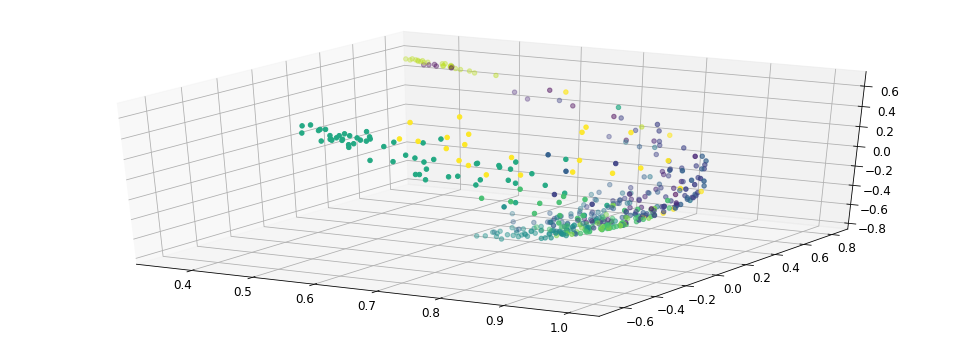

In [336]:
ax = plt.axes(projection='3d')
ax.scatter(dtm_lsa[:,0], dtm_lsa[:,1], dtm_lsa[:,2], c=DESC_DFS[0].GICS, cmap='viridis')

### Old Code

##### R2 Evaluation (longer code)

In [ ]:
# R2_dict = {}

# for cluster_mtd in tqdm(all_cluster_filtered.columns):
#     if cluster_mtd == 'Ticker':
#         continue
    
#     R2_list = []
#     for i in range(NUM_INDUSTRIES):
#         cluster_tickers = all_cluster_filtered[all_cluster_filtered[cluster_mtd] == i].Ticker
#         cluster_ticker_returns = ticker_return_df[cluster_tickers]
#         mean_return = cluster_ticker_returns.mean(axis=1)
#         cluster_R2 = [mean_return.corr(ticker_returns) for _, ticker_returns in cluster_ticker_returns.iteritems()]
#         R2_list.extend(cluster_R2)
#     avg_R2 = sum(R2_list)/len(R2_list)
#     R2_dict[cluster_mtd] = avg_R2

# avg_R2_df = pd.DataFrame.from_dict(R2_dict, orient='index', columns=['Average R2'])

In [ ]:
# GICS_R2 = R2_dict['GICS']
# MTDS = ['kmeans', 'gmm']
# list_of_dfs = []

# for mtd in MTDS:
#     mtd_df = avg_R2_df.filter(regex=mtd, axis=0)
#     mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
#     mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
#     list_of_dfs.append(mtd_df)

# avg_R2_pivot_df = pd.concat(list_of_dfs, axis=1)
# print(GICS_R2)
# avg_R2_pivot_df

##### RV Evaluation (longer code)

In [287]:
# RATIO_NAMES_LIST = list(ticker_ratios_df.columns[1:])
# all_cluster_with_ratio = pd.merge(all_cluster_filtered, ticker_ratios_normalised_df, on='Ticker')
# ratio_variation_dict = {}

# for cluster_mtd in tqdm(all_cluster_filtered.columns):
#     if cluster_mtd == 'Ticker':
#         continue
        
#     filter_df = all_cluster_with_ratio[[cluster_mtd] + RATIO_NAMES_LIST]
#     v_m = all_cluster_with_ratio[RATIO_NAMES_LIST].mean()
#     variation_df = filter_df.groupby(cluster_mtd).aggregate(cluster_variation)
#     variation_series = variation_df.sum()
#     N_ratios = ticker_ratios_normalised_df[RATIO_NAMES_LIST].count() # count non-NaN values

#     normaliser_series = ticker_ratios_normalised_df[RATIO_NAMES_LIST].std()

#     sigma_v = list(np.sqrt(variation_series/N_ratios) / normaliser_series)
#     ratio_variation_dict[cluster_mtd] = sigma_v

# ratio_variation_df = pd.DataFrame.from_dict(ratio_variation_dict, orient='index', columns=RATIO_NAMES_LIST)
# ratio_variation_df['Average Ratio Variation'] = ratio_variation_df.mean(axis=1)

In [ ]:
# avg_ratio_df = ratio_variation_df[['Average Ratio Variation']]
# GICS_RATIO = ratio_variation_df.loc['GICS', 'Average Ratio Variation']
# MTDS = ['kmeans', 'gmm']
# list_of_dfs = []

# for mtd in MTDS:
#     mtd_df = avg_ratio_df.filter(regex=mtd, axis=0)
#     mtd_df.index = mtd_df.index.map(lambda s: s.split('_')[1])
#     mtd_df.columns = [mtd]  #(columns = {'test':'TEST'}, inplace = True) 
#     list_of_dfs.append(mtd_df)

# avg_ratio_pivot_df = pd.concat(list_of_dfs, axis=1)
# print(GICS_RATIO)
# avg_ratio_pivot_df

### Random

##### Cosine Similarity

In [ ]:
# Plotting for 2D
%pylab inline

xs = [w[0] for w in dtm_lsa]
ys = [w[1] for w in dtm_lsa]
xs, ys

figure()
plt.scatter(xs,ys)
xlabel('First principal component')
ylabel('Second principal component')
title('Plot of points against LSA principal components')

In [ ]:
def cosine_similarity(dtm):
    '''
    input: Doc Matrix
    output: list of lists indicating clusters
    '''
    corr = np.asarray(numpy.asmatrix(dtm_lsa) * numpy.asmatrix(dtm_lsa).T)
    
    L = dtm.shape[0]
    clusters = [[i] for i in range(L)]
    
    while (len(clusters) != NUM_INDUSTRIES):
        L = len(clusters)
        max_similarity = -1
        max_similarity_clusters = (None, None)
        for i in range(L):
            for j in range(i+1,L):
                cluster_1 = clusters[i]
                cluster_2 = clusters[j]
                n = len(cluster_1) * len(cluster_2)
                
                # Similarity
                total_similarity = 0
                for cpy_1 in cluster_1:
                    for cpy_2 in cluster_2:
                        print(cpy_1, cpy_2)
                        total_similarity += corr[cpy_1][cpy_2]
                similarity = total_similarity / n
                
                if similarity > max_similarity:
                    max_similarity = similarity 
                    max_similarity_clusters = (i, j)
        
        # Merge max_similarity clusters
        cluster_merge = clusters.pop(max_similarity_clusters[1])
        clusters[max_similarity_clusters[0]].append(cluster_merge)
        print(L)
    return clusters

|Embedding model|R2|proportion of right classification|
|----------------|--------|--------|
| LSI length 200 | 0.4537 | 0.4962 |
| LSI length 300 | 0.4459 | 0.4768 |
| LSI length 400 | 0.4421 | 0.4072 |
| LSI length 500 | 0.4554 | 0.4244 |
| LSI length 600 | 0.4362 | 0.4409 |
| LSI length 700 | 0.4407 | 0.3842 |
| LSI length 800 | 0.4417 | 0.4921 |
| LSI length 900 | 0.4478 | 0.4005 |
| LSI length 1000 | 0.4403 | 0.4068 |
| LSI length 1100 | 0.4380 | 0.3933 |